# Modelling, Simulation and Optimization (H9MSO) Project

### Srijan Kumar Pandey.
### MSc. Data Analytics
### x18127312@student.ncirl.ie

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
   <ul class="toc-item">
      <li><span><a href="#install-pre-requisite" data-toc-modified-id="pre-requisite"><span class="toc-item-num"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intorduction</a></span></li>
      <li><span><a href="#Load-Libraries" data-toc-modified-id="Load-Libraries-1"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Libraries</a></span></li>
      <li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-2"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare Data</a></span>
        <ul class="toc-item">
            <li><span><a href="#Reference-Simulation" data-toc-modified-id="Reference-Simulation-7.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Convert Distance(in meters)</a></span></li>
            <li><span><a href="#Simulating-an-Incident" data-toc-modified-id="Simulating-an-Incident-7.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Convert Time (in seconds)</a></span></li>
         </ul>
      </li>
      <li><span><a href="#Trains" data-toc-modified-id="Base"><span class="toc-item-num">4&nbsp;&nbsp;</span>Base Class</a></span></li>      
      <li><span><a href="#TrainProcess" data-toc-modified-id="TrainProcess"><span class="toc-item-num">5&nbsp;&nbsp;</span>TrainProcess Class</a></span></li>
      <li><span><a href="#simulation" data-toc-modified-id="simulation"><span class="toc-item-num">6&nbsp;&nbsp;</span>Simulation</a></span></li>
      <li><span><a href="#optimization" data-toc-modified-id="optimization"><span class="toc-item-num">7&nbsp;&nbsp;</span>Optimization</a></span></li>
      <li><span><a href="#min-time" data-toc-modified-id="min-time"><span class="toc-item-num">8&nbsp;&nbsp;</span>Minimize Overall Time</a></span></li>
      <li><span><a href="#Simulating-an-Incident" data-toc-modified-id="Simulating-an-Incident"><span class="toc-item-num">9&nbsp;&nbsp;</span>Simulating an Incident</a></span></li>
      <li><span><a href="#calculate" data-toc-modified-id="calculate"><span class="toc-item-num">10&nbsp;&nbsp;</span>Maximize the throughput passenger (Poisson Distribution)</a></span></li>
      <li><span><a href="#References" data-toc-modified-id="References"><span class="toc-item-num">11&nbsp;&nbsp;</span>References</a></span></li>      
   </ul>
</div>

# 1 Introduction

Simulation & Optimization is performed in this project in HS2 line from London to Birmingham, by considering some hypotheses which are listed below. This method would help to decide the optimal number of signalling blocks between stations in London Old Oak and Birmingham Interchange. This simulation will also help the throughput of trains/hr as well as max the throughput of the passenger on every train.

<a id="assumptions"></a>

###Assumptions
The following are the assumptions considered while building this simulation.
1. No delay due to weather and wind conditions, i.e. the normal weather is assumed.<br/> 

2. Two types of signalling blocks are considered. The first signalling block is the one which has known travelling times (train is expected to be idle) and the other signalling block is the one with known distance (train will achieve max speed).<br/>  London Euston to London Old Oak and Birmingham Interchange to Birmingham Curzon Street has first type of signalling blocks. This information is mentioned in the topic so, no adjustments are made. The second kind of signalling blocks is located within the known distance of 145kms between London Old Oak and Birmingham Interchange stations. The number of blocks between these stations are unknown and are not mentioned in the question. Hence, the effort is made to find the optimum number of blocks between London Old Oak and Birmingham Interchange.<br/> 

3. The following hypothesis is that the train will start acceleration from first signalling block, i.e. when leaving from London Old Oak and will decelerate at the end of the end signalling block i.e. when reaching the Birmingham Interchange.<br/> 
4. Final Assumption would be to find the passenger movement time at the station. 1 minute is the time which is assumed. 


###Install Pre-Requisite libraries which starts by installing simpy for simulation

In [1]:
!pip install simpy

###2 Loading required Libraries

In [2]:
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import random 
import math
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
import simpy
from simpy import events as evt
from numpy import random

### 3 Data preparation by loading it in jupyter

In [3]:
dataset=pd.read_csv('C:/Users/srija/OneDrive/Desktop/TrainSched_data.xls')
dataframe = pd.DataFrame({'train_number' : [], 'signal_count':[], 'London Euston':[], 'London Old Oak':[], 'Birmingham Interchange':[], 'Birmingham Curzon':[], 'travel_time':[]})

In [4]:
dataset.head()

,Line,From,To,Distance,Running Time,Signal Blocks
0,HS2,London Euston,London Old Oak,23,5,1
1,HS2,London Old Oak,Birmingham Interchange,145,30,14
2,HS2,Birmingham Interchange,Birmingham Curzon,42,9,2


## 3.1 Converting distances from kilometers to meters

In [5]:
dataset['Distance']=dataset['Distance'].apply(lambda x: int(x*1000))

In [6]:
dataset.head()

,Line,From,To,Distance,Running Time,Signal Blocks
0,HS2,London Euston,London Old Oak,23000,5,1
1,HS2,London Old Oak,Birmingham Interchange,145000,30,14
2,HS2,Birmingham Interchange,Birmingham Curzon,42000,9,2


###3.2 Converting Time into Seconds

In [7]:
dataset['Running Time']=dataset['Running Time'].apply(lambda x: int(x*60))

In [8]:
dataset.head()

,Line,From,To,Distance,Running Time,Signal Blocks
0,HS2,London Euston,London Old Oak,23000,300,1
1,HS2,London Old Oak,Birmingham Interchange,145000,1800,14
2,HS2,Birmingham Interchange,Birmingham Curzon,42000,540,2


###4 We will create the Basic Class in this section

######This class has all the methods available. which will be used by other classes and methods

In [9]:
class Basic(object):
  """This is a Basic class that has methods which will be used throughout this project. """
  def __init__(self, env=None):
    self.env = env

  def currentTime(self):
      return self.formattedSystemTime(self.env.now)
  
  def formattedSystemTime(self, time):
    time=int(time)
    return f"{time//3600:02d}:{(time%3600)//60:02d}:{time%60:02d}"

  def parseTime(self, s):
    """ Converting Time in to seconds. """
    if isinstance(s, str):
        parts=s.split(':')
        if len(parts)>=2:
            hours=int(parts[0])
            minutes=int(parts[1])
            seconds=0 if len(parts)==2 else int(parts[2])
            return 3600*hours+60*minutes+seconds
    # any wrong formats will be passed through and may cause 
    # an error at a later stage
    return s

### 5 Trains

In [28]:
class HSTrain(object): 
    def __init__(self, env, that, maxPassengers):
        self.env = env
        self.that = that;
        self.Basic = Basic(env)
        self.max_speed_time =115.7 #in seconds
        self.stop_time = 231.4 #in seconds
        self.inital_acc = 0.72 #meter per second square
        self.deceleration = 2.5 #meter per second square
        self.maxP  = maxPassengers
        self.travelling_passengers = 0
        self.p =0
    
    def isMaxSpeedAchieved(self, total_traveling_time):
      if(total_traveling_time - self.stop_time > self.max_speed_time):
          return True
      else:
        return False
    def getOff(self, num):
        if self.p >= num:
            print(f"{num:d} passengers got off")
            self.p -= num
        else:
            num = self.p
            print(f"train is empty - only {num:d} passengers got off")
            self.p = 0

    '''getOn() - Passengers board the train
       output - returns number of passengers that board the train'''
    def getOn(self, num, here, train_number):
        if (self.maxP is None) or (self.p + num <= self.maxP):
            print(f"{num:d} passengers got on " + here + "for train " + str(train_number)) 
            self.p += num
        else:
            num = self.maxP - self.p
            print(f"train is full - only {num:d} passengers got on")
            self.p = self.maxP
    
    def process(self, train_no, wait_time, maxPassengers): 
      """ This process will control train movement between statations."""
      here = self.that.stations()[0] 
      y = 0
      y = random.poisson(294) #genrating poisson random. 
      self.getOn(y, here, train_no) #Passenger get on statation
      self.travelling_passengers=y  #total traveling passenger
      station_passenger.at[f'{train_no+1}', here]= self.travelling_passengers      
      train_name = '[Train Number - '+f"{train_no+1:2d}"+']'
            
      index = 0      
      for station in self.that.stations()[1:]:        
        data=dataset[dataset['From']==here]
        runTime=data.iloc[0].at['Running Time']
        no_of_block = data.iloc[0].at['Signal Blocks']
        
        print(f"{self.Basic.currentTime():s} {train_name:s} starting from {here:s}")
        if(self.isMaxSpeedAchieved(runTime)):#checking weather train can achieve max speed between station
            print(f"{self.Basic.currentTime():s} {train_name:s} is Runing at a minimum acclearation")
            yield self.env.timeout(self.max_speed_time) #intial acceleration to achieve max speed
            print(f"{self.Basic.currentTime():s} {train_name:s} 300km/h speed is achieved.")
            yield self.env.timeout(runTime - self.max_speed_time - self.stop_time) #intial acceleration to achieve max speed
        else:
            print(f"{self.Basic.currentTime():s} {train_name:s} is Runing at a minimum acclearation")
            yield self.env.timeout(runTime - self.stop_time) #Train will run only given seconds
      
        drive = runTime/no_of_block
        for sig in self.that.blocks()[index]:#blocks between station 
            with sig.request() as req:
                yield req
                if(self.isMaxSpeedAchieved(runTime)): #if max speed achieve yeilding time to cross that block.    
                  yield self.env.timeout(drive)                  
                here=station  
        index+=1
        print(f"{self.Basic.currentTime():s} {train_name:s} is deceleration.")
        yield self.env.timeout(self.stop_time) #stoping train by providing deceleration 
        print(f"{self.Basic.currentTime():s} {train_name:s} arr {here:s}")
        yield self.env.timeout(wait_time)
        

### 6 Network Class

In [29]:
class Net(object):
    def __init__(self, start, end, interval, train_count, wait_time, maxPassengers=400):
      self.interval = interval
      self.env=simpy.Environment()
      self.t_count = train_count
      self.w_time = wait_time
      self.pas_count = maxPassengers
      self.train = HSTrain(self.env, self, self.pas_count)
      self.Basic = Basic(self.env)
      self.start = self.Basic.parseTime(start)
      self.stop = self.Basic.parseTime(end)


    def stations(self):
      """ station name from list. """
      stations=dataset['From'].to_list()
      stations+=[dataset['To'].to_list() [-1]]
      return stations 

    def updateSignalCount(self, count):
      """ This method return signal count between stations."""
      dataset['Signal Blocks'][1] = count

    def incident(self, wait_time):
      """" This method change gloal wait time """
      if wait_time:
        return wait_time
      else:
        return 60

    def trainCount(self, train_count):
      """ This method check for train counts if not avialble use (self.stop-self.start)/self.interval to calculate it."""
      if train_count:
        return train_count
      else:
        return int((self.stop-self.start)/self.interval)

    def process(self): 
      """ Starting Train simulatin process."""     
      yield self.env.timeout(self.start-self.env.now) 
      for train_no in range(self.trainCount(self.t_count)):          
          self.env.process(self.train.process(train_no, self.incident(self.w_time), self.pas_count))
          yield self.env.timeout(self.interval)

    def blocks(self):
      """ Signaling Block between station. creating resource as signaling block."""
      blocks_list = []
      here = self.stations()[0]

      for dest in self.stations()[1:]:
          dest_blocks = []
          desRow = dataset[dataset['From'] == here]
          no_of_blocks = desRow.iloc[0].at['Signal Blocks']
          for i in range(no_of_blocks):
              b = simpy.Resource(self.env, capacity=1)
              dest_blocks.append(b)
              
          blocks_list.append(dest_blocks)
          here=dest
      return blocks_list

    def runSimulation(self):
      """ starting process. """
      self.env.process(self.process())
      self.env.run()

### 7 Simulation

In [30]:
station_passenger = pd.DataFrame(index = [f"{i}" for i in range(11)])
network=Net("06:00", "07:00", 180, None, None)
network.runSimulation()

309 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acclearation
06:01:08 [Train Number -  1] is deceleration.
train is full - only 91 passengers got on
06:03:00 [Train Number -  2] starting from London Euston
06:03:00 [Train Number -  2] is Runing at a minimum acclearation
06:04:08 [Train Number -  2] is deceleration.
06:05:00 [Train Number -  1] arr London Old Oak
train is full - only 0 passengers got on
06:06:00 [Train Number -  3] starting from London Euston
06:06:00 [Train Number -  3] is Runing at a minimum acclearation
06:06:00 [Train Number -  1] starting from London Old Oak
06:06:00 [Train Number -  1] is Runing at a minimum acclearation
06:07:08 [Train Number -  3] is deceleration.
06:07:55 [Train Number -  1] 300km/h speed is achieved.
06:08:00 [Train Number -  2] arr London Old Oak
train is full - only 0 passengers got on
06:09:00 [Train Number -  4] starting from London 

07:39:59 [Train Number - 12] starting from Birmingham Interchange
07:39:59 [Train Number - 12] is Runing at a minimum acclearation
07:39:59 [Train Number -  6] arr Birmingham Curzon
07:41:08 [Train Number - 14] is deceleration.
07:41:55 [Train Number - 12] 300km/h speed is achieved.
07:41:59 [Train Number - 13] arr Birmingham Interchange
07:42:08 [Train Number -  8] is deceleration.
07:42:59 [Train Number - 13] starting from Birmingham Interchange
07:42:59 [Train Number - 13] is Runing at a minimum acclearation
07:42:59 [Train Number -  7] arr Birmingham Curzon
07:44:08 [Train Number - 15] is deceleration.
07:44:55 [Train Number - 13] 300km/h speed is achieved.
07:44:59 [Train Number - 14] arr Birmingham Interchange
07:45:08 [Train Number -  9] is deceleration.
07:45:59 [Train Number - 14] starting from Birmingham Interchange
07:45:59 [Train Number - 14] is Runing at a minimum acclearation
07:45:59 [Train Number -  8] arr Birmingham Curzon
07:47:08 [Train Number - 16] is deceleration.


In [31]:
dataset.head()

,Line,From,To,Distance,Running Time,Signal Blocks
0,HS2,London Euston,London Old Oak,23000,300,1
1,HS2,London Old Oak,Birmingham Interchange,145000,1800,14
2,HS2,Birmingham Interchange,Birmingham Curzon,42000,540,2


### 8 Optimisation technique (second part)

Simulation 

numbers of trains per hour n ∈ {1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20}

signalling blocks k ∈ {1, ..., 15} 

In [34]:
def simulateBlockWithTrain():  
  train_per_hour = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20]   
  for train_count in train_per_hour:     
    for signal_count in range(1, 13):      
      network=Net("06:00", "07:00", 180, train_count, None)
      network.updateSignalCount(signal_count)    
      network.runSimulation()

In [35]:
simulateBlockWithTrain()

C:\Users\srija\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


328 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acclearation
06:01:08 [Train Number -  1] is deceleration.
06:05:00 [Train Number -  1] arr London Old Oak
06:06:00 [Train Number -  1] starting from London Old Oak
06:06:00 [Train Number -  1] is Runing at a minimum acclearation
06:07:55 [Train Number -  1] 300km/h speed is achieved.
07:02:08 [Train Number -  1] is deceleration.
07:06:00 [Train Number -  1] arr Birmingham Interchange
07:07:00 [Train Number -  1] starting from Birmingham Interchange
07:07:00 [Train Number -  1] is Runing at a minimum acclearation
07:08:55 [Train Number -  1] 300km/h speed is achieved.
07:21:08 [Train Number -  1] is deceleration.
07:25:00 [Train Number -  1] arr Birmingham Curzon
287 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acclearation
06:

06:09:00 [Train Number -  2] starting from London Old Oak
06:09:00 [Train Number -  2] is Runing at a minimum acclearation
06:10:55 [Train Number -  2] 300km/h speed is achieved.
07:02:08 [Train Number -  1] is deceleration.
07:05:08 [Train Number -  2] is deceleration.
07:06:00 [Train Number -  1] arr Birmingham Interchange
07:07:00 [Train Number -  1] starting from Birmingham Interchange
07:07:00 [Train Number -  1] is Runing at a minimum acclearation
07:08:55 [Train Number -  1] 300km/h speed is achieved.
07:09:00 [Train Number -  2] arr Birmingham Interchange
07:10:00 [Train Number -  2] starting from Birmingham Interchange
07:10:00 [Train Number -  2] is Runing at a minimum acclearation
07:11:55 [Train Number -  2] 300km/h speed is achieved.
07:21:08 [Train Number -  1] is deceleration.
07:24:08 [Train Number -  2] is deceleration.
07:25:00 [Train Number -  1] arr Birmingham Curzon
07:28:00 [Train Number -  2] arr Birmingham Curzon
297 passengers got on London Eustonfor train 0
06

07:02:08 [Train Number -  1] is deceleration.
07:05:08 [Train Number -  2] is deceleration.
07:06:00 [Train Number -  1] arr Birmingham Interchange
07:07:00 [Train Number -  1] starting from Birmingham Interchange
07:07:00 [Train Number -  1] is Runing at a minimum acclearation
07:08:55 [Train Number -  1] 300km/h speed is achieved.
07:09:00 [Train Number -  2] arr Birmingham Interchange
07:10:00 [Train Number -  2] starting from Birmingham Interchange
07:10:00 [Train Number -  2] is Runing at a minimum acclearation
07:11:55 [Train Number -  2] 300km/h speed is achieved.
07:21:08 [Train Number -  1] is deceleration.
07:24:08 [Train Number -  2] is deceleration.
07:25:00 [Train Number -  1] arr Birmingham Curzon
07:28:00 [Train Number -  2] arr Birmingham Curzon
309 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acclearation
06:01:08 [Train Number -  1] is deceleration.
train is full

07:06:00 [Train Number -  1] arr Birmingham Interchange
07:07:00 [Train Number -  1] starting from Birmingham Interchange
07:07:00 [Train Number -  1] is Runing at a minimum acclearation
07:08:08 [Train Number -  3] is deceleration.
07:08:55 [Train Number -  1] 300km/h speed is achieved.
07:09:00 [Train Number -  2] arr Birmingham Interchange
07:10:00 [Train Number -  2] starting from Birmingham Interchange
07:10:00 [Train Number -  2] is Runing at a minimum acclearation
07:11:55 [Train Number -  2] 300km/h speed is achieved.
07:12:00 [Train Number -  3] arr Birmingham Interchange
07:13:00 [Train Number -  3] starting from Birmingham Interchange
07:13:00 [Train Number -  3] is Runing at a minimum acclearation
07:14:55 [Train Number -  3] 300km/h speed is achieved.
07:21:08 [Train Number -  1] is deceleration.
07:24:08 [Train Number -  2] is deceleration.
07:25:00 [Train Number -  1] arr Birmingham Curzon
07:27:08 [Train Number -  3] is deceleration.
07:28:00 [Train Number -  2] arr Bir

07:13:00 [Train Number -  3] starting from Birmingham Interchange
07:13:00 [Train Number -  3] is Runing at a minimum acclearation
07:14:55 [Train Number -  3] 300km/h speed is achieved.
07:15:00 [Train Number -  4] arr Birmingham Interchange
07:16:00 [Train Number -  4] starting from Birmingham Interchange
07:16:00 [Train Number -  4] is Runing at a minimum acclearation
07:17:55 [Train Number -  4] 300km/h speed is achieved.
07:21:08 [Train Number -  1] is deceleration.
07:24:08 [Train Number -  2] is deceleration.
07:25:00 [Train Number -  1] arr Birmingham Curzon
07:27:08 [Train Number -  3] is deceleration.
07:28:00 [Train Number -  2] arr Birmingham Curzon
07:30:08 [Train Number -  4] is deceleration.
07:31:00 [Train Number -  3] arr Birmingham Curzon
07:34:00 [Train Number -  4] arr Birmingham Curzon
295 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acclearation
06:01:08 [Tra

06:07:08 [Train Number -  3] is deceleration.
06:07:55 [Train Number -  1] 300km/h speed is achieved.
06:08:00 [Train Number -  2] arr London Old Oak
train is full - only 0 passengers got on
06:09:00 [Train Number -  4] starting from London Euston
06:09:00 [Train Number -  4] is Runing at a minimum acclearation
06:09:00 [Train Number -  2] starting from London Old Oak
06:09:00 [Train Number -  2] is Runing at a minimum acclearation
06:10:08 [Train Number -  4] is deceleration.
06:10:55 [Train Number -  2] 300km/h speed is achieved.
06:11:00 [Train Number -  3] arr London Old Oak
06:12:00 [Train Number -  3] starting from London Old Oak
06:12:00 [Train Number -  3] is Runing at a minimum acclearation
06:13:55 [Train Number -  3] 300km/h speed is achieved.
06:14:00 [Train Number -  4] arr London Old Oak
06:15:00 [Train Number -  4] starting from London Old Oak
06:15:00 [Train Number -  4] is Runing at a minimum acclearation
06:16:55 [Train Number -  4] 300km/h speed is achieved.
07:02:08

07:02:08 [Train Number -  1] is deceleration.
07:05:08 [Train Number -  2] is deceleration.
07:06:00 [Train Number -  1] arr Birmingham Interchange
07:07:00 [Train Number -  1] starting from Birmingham Interchange
07:07:00 [Train Number -  1] is Runing at a minimum acclearation
07:08:08 [Train Number -  3] is deceleration.
07:08:55 [Train Number -  1] 300km/h speed is achieved.
07:09:00 [Train Number -  2] arr Birmingham Interchange
07:10:00 [Train Number -  2] starting from Birmingham Interchange
07:10:00 [Train Number -  2] is Runing at a minimum acclearation
07:11:08 [Train Number -  4] is deceleration.
07:11:55 [Train Number -  2] 300km/h speed is achieved.
07:12:00 [Train Number -  3] arr Birmingham Interchange
07:13:00 [Train Number -  3] starting from Birmingham Interchange
07:13:00 [Train Number -  3] is Runing at a minimum acclearation
07:14:55 [Train Number -  3] 300km/h speed is achieved.
07:15:00 [Train Number -  4] arr Birmingham Interchange
07:16:00 [Train Number -  4] st

train is full - only 0 passengers got on
06:06:00 [Train Number -  3] starting from London Euston
06:06:00 [Train Number -  3] is Runing at a minimum acclearation
06:06:00 [Train Number -  1] starting from London Old Oak
06:06:00 [Train Number -  1] is Runing at a minimum acclearation
06:07:08 [Train Number -  3] is deceleration.
06:07:55 [Train Number -  1] 300km/h speed is achieved.
06:08:00 [Train Number -  2] arr London Old Oak
train is full - only 0 passengers got on
06:09:00 [Train Number -  4] starting from London Euston
06:09:00 [Train Number -  4] is Runing at a minimum acclearation
06:09:00 [Train Number -  2] starting from London Old Oak
06:09:00 [Train Number -  2] is Runing at a minimum acclearation
06:10:08 [Train Number -  4] is deceleration.
06:10:55 [Train Number -  2] 300km/h speed is achieved.
06:11:00 [Train Number -  3] arr London Old Oak
train is full - only 0 passengers got on
06:12:00 [Train Number -  5] starting from London Euston
06:12:00 [Train Number -  5] i

06:12:00 [Train Number -  5] starting from London Euston
06:12:00 [Train Number -  5] is Runing at a minimum acclearation
06:12:00 [Train Number -  3] starting from London Old Oak
06:12:00 [Train Number -  3] is Runing at a minimum acclearation
06:13:08 [Train Number -  5] is deceleration.
06:13:55 [Train Number -  3] 300km/h speed is achieved.
06:14:00 [Train Number -  4] arr London Old Oak
06:15:00 [Train Number -  4] starting from London Old Oak
06:15:00 [Train Number -  4] is Runing at a minimum acclearation
06:16:55 [Train Number -  4] 300km/h speed is achieved.
06:17:00 [Train Number -  5] arr London Old Oak
06:18:00 [Train Number -  5] starting from London Old Oak
06:18:00 [Train Number -  5] is Runing at a minimum acclearation
06:19:55 [Train Number -  5] 300km/h speed is achieved.
07:02:08 [Train Number -  1] is deceleration.
07:05:08 [Train Number -  2] is deceleration.
07:06:00 [Train Number -  1] arr Birmingham Interchange
07:07:00 [Train Number -  1] starting from Birmingh

07:13:00 [Train Number -  3] starting from Birmingham Interchange
07:13:00 [Train Number -  3] is Runing at a minimum acclearation
07:14:08 [Train Number -  5] is deceleration.
07:14:55 [Train Number -  3] 300km/h speed is achieved.
07:15:00 [Train Number -  4] arr Birmingham Interchange
07:16:00 [Train Number -  4] starting from Birmingham Interchange
07:16:00 [Train Number -  4] is Runing at a minimum acclearation
07:17:55 [Train Number -  4] 300km/h speed is achieved.
07:18:00 [Train Number -  5] arr Birmingham Interchange
07:19:00 [Train Number -  5] starting from Birmingham Interchange
07:19:00 [Train Number -  5] is Runing at a minimum acclearation
07:20:55 [Train Number -  5] 300km/h speed is achieved.
07:21:08 [Train Number -  1] is deceleration.
07:24:08 [Train Number -  2] is deceleration.
07:25:00 [Train Number -  1] arr Birmingham Curzon
07:27:08 [Train Number -  3] is deceleration.
07:28:00 [Train Number -  2] arr Birmingham Curzon
07:30:08 [Train Number -  4] is decelerat

07:25:00 [Train Number -  1] arr Birmingham Curzon
07:27:08 [Train Number -  3] is deceleration.
07:28:00 [Train Number -  2] arr Birmingham Curzon
07:30:08 [Train Number -  4] is deceleration.
07:31:00 [Train Number -  3] arr Birmingham Curzon
07:33:08 [Train Number -  5] is deceleration.
07:34:00 [Train Number -  4] arr Birmingham Curzon
07:37:00 [Train Number -  5] arr Birmingham Curzon
290 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acclearation
06:01:08 [Train Number -  1] is deceleration.
train is full - only 110 passengers got on
06:03:00 [Train Number -  2] starting from London Euston
06:03:00 [Train Number -  2] is Runing at a minimum acclearation
06:04:08 [Train Number -  2] is deceleration.
06:05:00 [Train Number -  1] arr London Old Oak
train is full - only 0 passengers got on
06:06:00 [Train Number -  3] starting from London Euston
06:06:00 [Train Number -  3] is Run

07:28:00 [Train Number -  2] arr Birmingham Curzon
07:30:08 [Train Number -  4] is deceleration.
07:31:00 [Train Number -  3] arr Birmingham Curzon
07:33:08 [Train Number -  5] is deceleration.
07:34:00 [Train Number -  4] arr Birmingham Curzon
07:36:08 [Train Number -  6] is deceleration.
07:37:00 [Train Number -  5] arr Birmingham Curzon
07:40:00 [Train Number -  6] arr Birmingham Curzon
301 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acclearation
06:01:08 [Train Number -  1] is deceleration.
train is full - only 99 passengers got on
06:03:00 [Train Number -  2] starting from London Euston
06:03:00 [Train Number -  2] is Runing at a minimum acclearation
06:04:08 [Train Number -  2] is deceleration.
06:05:00 [Train Number -  1] arr London Old Oak
train is full - only 0 passengers got on
06:06:00 [Train Number -  3] starting from London Euston
06:06:00 [Train Number -  3] is Runi

07:28:00 [Train Number -  2] arr Birmingham Curzon
07:30:08 [Train Number -  4] is deceleration.
07:31:00 [Train Number -  3] arr Birmingham Curzon
07:33:08 [Train Number -  5] is deceleration.
07:34:00 [Train Number -  4] arr Birmingham Curzon
07:36:08 [Train Number -  6] is deceleration.
07:37:00 [Train Number -  5] arr Birmingham Curzon
07:40:00 [Train Number -  6] arr Birmingham Curzon
315 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acclearation
06:01:08 [Train Number -  1] is deceleration.
train is full - only 85 passengers got on
06:03:00 [Train Number -  2] starting from London Euston
06:03:00 [Train Number -  2] is Runing at a minimum acclearation
06:04:08 [Train Number -  2] is deceleration.
06:05:00 [Train Number -  1] arr London Old Oak
train is full - only 0 passengers got on
06:06:00 [Train Number -  3] starting from London Euston
06:06:00 [Train Number -  3] is Runi

07:19:00 [Train Number -  5] starting from Birmingham Interchange
07:19:00 [Train Number -  5] is Runing at a minimum acclearation
07:20:55 [Train Number -  5] 300km/h speed is achieved.
07:21:00 [Train Number -  6] arr Birmingham Interchange
07:21:08 [Train Number -  1] is deceleration.
07:22:00 [Train Number -  6] starting from Birmingham Interchange
07:22:00 [Train Number -  6] is Runing at a minimum acclearation
07:23:55 [Train Number -  6] 300km/h speed is achieved.
07:24:08 [Train Number -  2] is deceleration.
07:25:00 [Train Number -  1] arr Birmingham Curzon
07:27:08 [Train Number -  3] is deceleration.
07:28:00 [Train Number -  2] arr Birmingham Curzon
07:30:08 [Train Number -  4] is deceleration.
07:31:00 [Train Number -  3] arr Birmingham Curzon
07:33:08 [Train Number -  5] is deceleration.
07:34:00 [Train Number -  4] arr Birmingham Curzon
07:36:08 [Train Number -  6] is deceleration.
07:37:00 [Train Number -  5] arr Birmingham Curzon
07:40:00 [Train Number -  6] arr Birmin

07:10:00 [Train Number -  2] starting from Birmingham Interchange
07:10:00 [Train Number -  2] is Runing at a minimum acclearation
07:11:08 [Train Number -  4] is deceleration.
07:11:55 [Train Number -  2] 300km/h speed is achieved.
07:12:00 [Train Number -  3] arr Birmingham Interchange
07:13:00 [Train Number -  3] starting from Birmingham Interchange
07:13:00 [Train Number -  3] is Runing at a minimum acclearation
07:14:08 [Train Number -  5] is deceleration.
07:14:55 [Train Number -  3] 300km/h speed is achieved.
07:15:00 [Train Number -  4] arr Birmingham Interchange
07:16:00 [Train Number -  4] starting from Birmingham Interchange
07:16:00 [Train Number -  4] is Runing at a minimum acclearation
07:17:08 [Train Number -  6] is deceleration.
07:17:55 [Train Number -  4] 300km/h speed is achieved.
07:18:00 [Train Number -  5] arr Birmingham Interchange
07:19:00 [Train Number -  5] starting from Birmingham Interchange
07:19:00 [Train Number -  5] is Runing at a minimum acclearation
07

06:22:08 [Train Number -  8] is deceleration.
06:22:55 [Train Number -  6] 300km/h speed is achieved.
06:23:00 [Train Number -  7] arr London Old Oak
06:24:00 [Train Number -  7] starting from London Old Oak
06:24:00 [Train Number -  7] is Runing at a minimum acclearation
06:25:55 [Train Number -  7] 300km/h speed is achieved.
06:26:00 [Train Number -  8] arr London Old Oak
06:27:00 [Train Number -  8] starting from London Old Oak
06:27:00 [Train Number -  8] is Runing at a minimum acclearation
06:28:55 [Train Number -  8] 300km/h speed is achieved.
07:02:08 [Train Number -  1] is deceleration.
07:05:08 [Train Number -  2] is deceleration.
07:06:00 [Train Number -  1] arr Birmingham Interchange
07:07:00 [Train Number -  1] starting from Birmingham Interchange
07:07:00 [Train Number -  1] is Runing at a minimum acclearation
07:08:08 [Train Number -  3] is deceleration.
07:08:55 [Train Number -  1] 300km/h speed is achieved.
07:09:00 [Train Number -  2] arr Birmingham Interchange
07:10:0

07:34:00 [Train Number -  4] arr Birmingham Curzon
07:36:08 [Train Number -  6] is deceleration.
07:37:00 [Train Number -  5] arr Birmingham Curzon
07:39:08 [Train Number -  7] is deceleration.
07:40:00 [Train Number -  6] arr Birmingham Curzon
07:42:08 [Train Number -  8] is deceleration.
07:43:00 [Train Number -  7] arr Birmingham Curzon
07:46:00 [Train Number -  8] arr Birmingham Curzon
265 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acclearation
06:01:08 [Train Number -  1] is deceleration.
train is full - only 135 passengers got on
06:03:00 [Train Number -  2] starting from London Euston
06:03:00 [Train Number -  2] is Runing at a minimum acclearation
06:04:08 [Train Number -  2] is deceleration.
06:05:00 [Train Number -  1] arr London Old Oak
train is full - only 0 passengers got on
06:06:00 [Train Number -  3] starting from London Euston
06:06:00 [Train Number -  3] is Run

07:19:00 [Train Number -  5] starting from Birmingham Interchange
07:19:00 [Train Number -  5] is Runing at a minimum acclearation
07:20:08 [Train Number -  7] is deceleration.
07:20:55 [Train Number -  5] 300km/h speed is achieved.
07:21:00 [Train Number -  6] arr Birmingham Interchange
07:21:08 [Train Number -  1] is deceleration.
07:22:00 [Train Number -  6] starting from Birmingham Interchange
07:22:00 [Train Number -  6] is Runing at a minimum acclearation
07:23:08 [Train Number -  8] is deceleration.
07:23:55 [Train Number -  6] 300km/h speed is achieved.
07:24:00 [Train Number -  7] arr Birmingham Interchange
07:24:08 [Train Number -  2] is deceleration.
07:25:00 [Train Number -  7] starting from Birmingham Interchange
07:25:00 [Train Number -  7] is Runing at a minimum acclearation
07:25:00 [Train Number -  1] arr Birmingham Curzon
07:26:55 [Train Number -  7] 300km/h speed is achieved.
07:27:00 [Train Number -  8] arr Birmingham Interchange
07:27:08 [Train Number -  3] is dece

06:19:08 [Train Number -  7] is deceleration.
06:19:55 [Train Number -  5] 300km/h speed is achieved.
06:20:00 [Train Number -  6] arr London Old Oak
train is full - only 0 passengers got on
06:21:00 [Train Number -  8] starting from London Euston
06:21:00 [Train Number -  8] is Runing at a minimum acclearation
06:21:00 [Train Number -  6] starting from London Old Oak
06:21:00 [Train Number -  6] is Runing at a minimum acclearation
06:22:08 [Train Number -  8] is deceleration.
06:22:55 [Train Number -  6] 300km/h speed is achieved.
06:23:00 [Train Number -  7] arr London Old Oak
06:24:00 [Train Number -  7] starting from London Old Oak
06:24:00 [Train Number -  7] is Runing at a minimum acclearation
06:25:55 [Train Number -  7] 300km/h speed is achieved.
06:26:00 [Train Number -  8] arr London Old Oak
06:27:00 [Train Number -  8] starting from London Old Oak
06:27:00 [Train Number -  8] is Runing at a minimum acclearation
06:28:55 [Train Number -  8] 300km/h speed is achieved.
07:02:08

07:25:00 [Train Number -  7] starting from Birmingham Interchange
07:25:00 [Train Number -  7] is Runing at a minimum acclearation
07:25:00 [Train Number -  1] arr Birmingham Curzon
07:26:55 [Train Number -  7] 300km/h speed is achieved.
07:27:00 [Train Number -  8] arr Birmingham Interchange
07:27:08 [Train Number -  3] is deceleration.
07:28:00 [Train Number -  8] starting from Birmingham Interchange
07:28:00 [Train Number -  8] is Runing at a minimum acclearation
07:28:00 [Train Number -  2] arr Birmingham Curzon
07:29:55 [Train Number -  8] 300km/h speed is achieved.
07:30:08 [Train Number -  4] is deceleration.
07:31:00 [Train Number -  3] arr Birmingham Curzon
07:33:08 [Train Number -  5] is deceleration.
07:34:00 [Train Number -  4] arr Birmingham Curzon
07:36:08 [Train Number -  6] is deceleration.
07:37:00 [Train Number -  5] arr Birmingham Curzon
07:39:08 [Train Number -  7] is deceleration.
07:40:00 [Train Number -  6] arr Birmingham Curzon
07:42:08 [Train Number -  8] is de

06:09:00 [Train Number -  4] is Runing at a minimum acclearation
06:09:00 [Train Number -  2] starting from London Old Oak
06:09:00 [Train Number -  2] is Runing at a minimum acclearation
06:10:08 [Train Number -  4] is deceleration.
06:10:55 [Train Number -  2] 300km/h speed is achieved.
06:11:00 [Train Number -  3] arr London Old Oak
train is full - only 0 passengers got on
06:12:00 [Train Number -  5] starting from London Euston
06:12:00 [Train Number -  5] is Runing at a minimum acclearation
06:12:00 [Train Number -  3] starting from London Old Oak
06:12:00 [Train Number -  3] is Runing at a minimum acclearation
06:13:08 [Train Number -  5] is deceleration.
06:13:55 [Train Number -  3] 300km/h speed is achieved.
06:14:00 [Train Number -  4] arr London Old Oak
train is full - only 0 passengers got on
06:15:00 [Train Number -  6] starting from London Euston
06:15:00 [Train Number -  6] is Runing at a minimum acclearation
06:15:00 [Train Number -  4] starting from London Old Oak
06:15

06:25:08 [Train Number -  9] is deceleration.
06:25:55 [Train Number -  7] 300km/h speed is achieved.
06:26:00 [Train Number -  8] arr London Old Oak
train is full - only 0 passengers got on
06:27:00 [Train Number - 10] starting from London Euston
06:27:00 [Train Number - 10] is Runing at a minimum acclearation
06:27:00 [Train Number -  8] starting from London Old Oak
06:27:00 [Train Number -  8] is Runing at a minimum acclearation
06:28:08 [Train Number - 10] is deceleration.
06:28:55 [Train Number -  8] 300km/h speed is achieved.
06:29:00 [Train Number -  9] arr London Old Oak
06:30:00 [Train Number -  9] starting from London Old Oak
06:30:00 [Train Number -  9] is Runing at a minimum acclearation
06:31:55 [Train Number -  9] 300km/h speed is achieved.
06:32:00 [Train Number - 10] arr London Old Oak
06:33:00 [Train Number - 10] starting from London Old Oak
06:33:00 [Train Number - 10] is Runing at a minimum acclearation
06:34:55 [Train Number - 10] 300km/h speed is achieved.
07:02:08

06:19:08 [Train Number -  7] is deceleration.
06:19:55 [Train Number -  5] 300km/h speed is achieved.
06:20:00 [Train Number -  6] arr London Old Oak
train is full - only 0 passengers got on
06:21:00 [Train Number -  8] starting from London Euston
06:21:00 [Train Number -  8] is Runing at a minimum acclearation
06:21:00 [Train Number -  6] starting from London Old Oak
06:21:00 [Train Number -  6] is Runing at a minimum acclearation
06:22:08 [Train Number -  8] is deceleration.
06:22:55 [Train Number -  6] 300km/h speed is achieved.
06:23:00 [Train Number -  7] arr London Old Oak
train is full - only 0 passengers got on
06:24:00 [Train Number -  9] starting from London Euston
06:24:00 [Train Number -  9] is Runing at a minimum acclearation
06:24:00 [Train Number -  7] starting from London Old Oak
06:24:00 [Train Number -  7] is Runing at a minimum acclearation
06:25:08 [Train Number -  9] is deceleration.
06:25:55 [Train Number -  7] 300km/h speed is achieved.
06:26:00 [Train Number -  

07:34:00 [Train Number - 10] starting from Birmingham Interchange
07:34:00 [Train Number - 10] is Runing at a minimum acclearation
07:34:00 [Train Number -  4] arr Birmingham Curzon
07:35:55 [Train Number - 10] 300km/h speed is achieved.
07:36:08 [Train Number -  6] is deceleration.
07:37:00 [Train Number -  5] arr Birmingham Curzon
07:39:08 [Train Number -  7] is deceleration.
07:40:00 [Train Number -  6] arr Birmingham Curzon
07:42:08 [Train Number -  8] is deceleration.
07:43:00 [Train Number -  7] arr Birmingham Curzon
07:45:08 [Train Number -  9] is deceleration.
07:46:00 [Train Number -  8] arr Birmingham Curzon
07:48:08 [Train Number - 10] is deceleration.
07:49:00 [Train Number -  9] arr Birmingham Curzon
07:52:00 [Train Number - 10] arr Birmingham Curzon
283 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acclearation
06:01:08 [Train Number -  1] is deceleration.
train is fu

07:13:00 [Train Number -  3] starting from Birmingham Interchange
07:13:00 [Train Number -  3] is Runing at a minimum acclearation
07:14:08 [Train Number -  5] is deceleration.
07:14:55 [Train Number -  3] 300km/h speed is achieved.
07:15:00 [Train Number -  4] arr Birmingham Interchange
07:16:00 [Train Number -  4] starting from Birmingham Interchange
07:16:00 [Train Number -  4] is Runing at a minimum acclearation
07:17:08 [Train Number -  6] is deceleration.
07:17:55 [Train Number -  4] 300km/h speed is achieved.
07:18:00 [Train Number -  5] arr Birmingham Interchange
07:19:00 [Train Number -  5] starting from Birmingham Interchange
07:19:00 [Train Number -  5] is Runing at a minimum acclearation
07:20:08 [Train Number -  7] is deceleration.
07:20:55 [Train Number -  5] 300km/h speed is achieved.
07:21:00 [Train Number -  6] arr Birmingham Interchange
07:21:08 [Train Number -  1] is deceleration.
07:22:00 [Train Number -  6] starting from Birmingham Interchange
07:22:00 [Train Numbe

07:02:08 [Train Number -  1] is deceleration.
07:05:08 [Train Number -  2] is deceleration.
07:06:00 [Train Number -  1] arr Birmingham Interchange
07:07:00 [Train Number -  1] starting from Birmingham Interchange
07:07:00 [Train Number -  1] is Runing at a minimum acclearation
07:08:08 [Train Number -  3] is deceleration.
07:08:55 [Train Number -  1] 300km/h speed is achieved.
07:09:00 [Train Number -  2] arr Birmingham Interchange
07:10:00 [Train Number -  2] starting from Birmingham Interchange
07:10:00 [Train Number -  2] is Runing at a minimum acclearation
07:11:08 [Train Number -  4] is deceleration.
07:11:55 [Train Number -  2] 300km/h speed is achieved.
07:12:00 [Train Number -  3] arr Birmingham Interchange
07:13:00 [Train Number -  3] starting from Birmingham Interchange
07:13:00 [Train Number -  3] is Runing at a minimum acclearation
07:14:08 [Train Number -  5] is deceleration.
07:14:55 [Train Number -  3] 300km/h speed is achieved.
07:15:00 [Train Number -  4] arr Birmingh

07:02:08 [Train Number -  1] is deceleration.
07:05:08 [Train Number -  2] is deceleration.
07:06:00 [Train Number -  1] arr Birmingham Interchange
07:07:00 [Train Number -  1] starting from Birmingham Interchange
07:07:00 [Train Number -  1] is Runing at a minimum acclearation
07:08:08 [Train Number -  3] is deceleration.
07:08:55 [Train Number -  1] 300km/h speed is achieved.
07:09:00 [Train Number -  2] arr Birmingham Interchange
07:10:00 [Train Number -  2] starting from Birmingham Interchange
07:10:00 [Train Number -  2] is Runing at a minimum acclearation
07:11:08 [Train Number -  4] is deceleration.
07:11:55 [Train Number -  2] 300km/h speed is achieved.
07:12:00 [Train Number -  3] arr Birmingham Interchange
07:13:00 [Train Number -  3] starting from Birmingham Interchange
07:13:00 [Train Number -  3] is Runing at a minimum acclearation
07:14:08 [Train Number -  5] is deceleration.
07:14:55 [Train Number -  3] 300km/h speed is achieved.
07:15:00 [Train Number -  4] arr Birmingh

07:02:08 [Train Number -  1] is deceleration.
07:05:08 [Train Number -  2] is deceleration.
07:06:00 [Train Number -  1] arr Birmingham Interchange
07:07:00 [Train Number -  1] starting from Birmingham Interchange
07:07:00 [Train Number -  1] is Runing at a minimum acclearation
07:08:08 [Train Number -  3] is deceleration.
07:08:55 [Train Number -  1] 300km/h speed is achieved.
07:09:00 [Train Number -  2] arr Birmingham Interchange
07:10:00 [Train Number -  2] starting from Birmingham Interchange
07:10:00 [Train Number -  2] is Runing at a minimum acclearation
07:11:08 [Train Number -  4] is deceleration.
07:11:55 [Train Number -  2] 300km/h speed is achieved.
07:12:00 [Train Number -  3] arr Birmingham Interchange
07:13:00 [Train Number -  3] starting from Birmingham Interchange
07:13:00 [Train Number -  3] is Runing at a minimum acclearation
07:14:08 [Train Number -  5] is deceleration.
07:14:55 [Train Number -  3] 300km/h speed is achieved.
07:15:00 [Train Number -  4] arr Birmingh

06:25:08 [Train Number -  9] is deceleration.
06:25:55 [Train Number -  7] 300km/h speed is achieved.
06:26:00 [Train Number -  8] arr London Old Oak
train is full - only 0 passengers got on
06:27:00 [Train Number - 10] starting from London Euston
06:27:00 [Train Number - 10] is Runing at a minimum acclearation
06:27:00 [Train Number -  8] starting from London Old Oak
06:27:00 [Train Number -  8] is Runing at a minimum acclearation
06:28:08 [Train Number - 10] is deceleration.
06:28:55 [Train Number -  8] 300km/h speed is achieved.
06:29:00 [Train Number -  9] arr London Old Oak
train is full - only 0 passengers got on
06:30:00 [Train Number - 11] starting from London Euston
06:30:00 [Train Number - 11] is Runing at a minimum acclearation
06:30:00 [Train Number -  9] starting from London Old Oak
06:30:00 [Train Number -  9] is Runing at a minimum acclearation
06:31:08 [Train Number - 11] is deceleration.
06:31:55 [Train Number -  9] 300km/h speed is achieved.
06:32:00 [Train Number - 1

07:31:00 [Train Number -  9] starting from Birmingham Interchange
07:31:00 [Train Number -  9] is Runing at a minimum acclearation
07:31:00 [Train Number -  3] arr Birmingham Curzon
07:32:08 [Train Number - 11] is deceleration.
07:32:55 [Train Number -  9] 300km/h speed is achieved.
07:33:00 [Train Number - 10] arr Birmingham Interchange
07:33:08 [Train Number -  5] is deceleration.
07:34:00 [Train Number - 10] starting from Birmingham Interchange
07:34:00 [Train Number - 10] is Runing at a minimum acclearation
07:34:00 [Train Number -  4] arr Birmingham Curzon
07:35:08 [Train Number - 12] is deceleration.
07:35:55 [Train Number - 10] 300km/h speed is achieved.
07:36:00 [Train Number - 11] arr Birmingham Interchange
07:36:08 [Train Number -  6] is deceleration.
07:37:00 [Train Number - 11] starting from Birmingham Interchange
07:37:00 [Train Number - 11] is Runing at a minimum acclearation
07:37:00 [Train Number -  5] arr Birmingham Curzon
07:38:55 [Train Number - 11] 300km/h speed is 

06:39:00 [Train Number - 12] starting from London Old Oak
06:39:00 [Train Number - 12] is Runing at a minimum acclearation
06:40:55 [Train Number - 12] 300km/h speed is achieved.
07:02:08 [Train Number -  1] is deceleration.
07:05:08 [Train Number -  2] is deceleration.
07:06:00 [Train Number -  1] arr Birmingham Interchange
07:07:00 [Train Number -  1] starting from Birmingham Interchange
07:07:00 [Train Number -  1] is Runing at a minimum acclearation
07:08:08 [Train Number -  3] is deceleration.
07:08:55 [Train Number -  1] 300km/h speed is achieved.
07:09:00 [Train Number -  2] arr Birmingham Interchange
07:10:00 [Train Number -  2] starting from Birmingham Interchange
07:10:00 [Train Number -  2] is Runing at a minimum acclearation
07:11:08 [Train Number -  4] is deceleration.
07:11:55 [Train Number -  2] 300km/h speed is achieved.
07:12:00 [Train Number -  3] arr Birmingham Interchange
07:13:00 [Train Number -  3] starting from Birmingham Interchange
07:13:00 [Train Number -  3] 

06:19:08 [Train Number -  7] is deceleration.
06:19:55 [Train Number -  5] 300km/h speed is achieved.
06:20:00 [Train Number -  6] arr London Old Oak
train is full - only 0 passengers got on
06:21:00 [Train Number -  8] starting from London Euston
06:21:00 [Train Number -  8] is Runing at a minimum acclearation
06:21:00 [Train Number -  6] starting from London Old Oak
06:21:00 [Train Number -  6] is Runing at a minimum acclearation
06:22:08 [Train Number -  8] is deceleration.
06:22:55 [Train Number -  6] 300km/h speed is achieved.
06:23:00 [Train Number -  7] arr London Old Oak
train is full - only 0 passengers got on
06:24:00 [Train Number -  9] starting from London Euston
06:24:00 [Train Number -  9] is Runing at a minimum acclearation
06:24:00 [Train Number -  7] starting from London Old Oak
06:24:00 [Train Number -  7] is Runing at a minimum acclearation
06:25:08 [Train Number -  9] is deceleration.
06:25:55 [Train Number -  7] 300km/h speed is achieved.
06:26:00 [Train Number -  

07:19:00 [Train Number -  5] starting from Birmingham Interchange
07:19:00 [Train Number -  5] is Runing at a minimum acclearation
07:20:08 [Train Number -  7] is deceleration.
07:20:55 [Train Number -  5] 300km/h speed is achieved.
07:21:00 [Train Number -  6] arr Birmingham Interchange
07:21:08 [Train Number -  1] is deceleration.
07:22:00 [Train Number -  6] starting from Birmingham Interchange
07:22:00 [Train Number -  6] is Runing at a minimum acclearation
07:23:08 [Train Number -  8] is deceleration.
07:23:55 [Train Number -  6] 300km/h speed is achieved.
07:24:00 [Train Number -  7] arr Birmingham Interchange
07:24:08 [Train Number -  2] is deceleration.
07:25:00 [Train Number -  7] starting from Birmingham Interchange
07:25:00 [Train Number -  7] is Runing at a minimum acclearation
07:25:00 [Train Number -  1] arr Birmingham Curzon
07:26:08 [Train Number -  9] is deceleration.
07:26:55 [Train Number -  7] 300km/h speed is achieved.
07:27:00 [Train Number -  8] arr Birmingham In

06:16:08 [Train Number -  6] is deceleration.
06:16:55 [Train Number -  4] 300km/h speed is achieved.
06:17:00 [Train Number -  5] arr London Old Oak
train is full - only 0 passengers got on
06:18:00 [Train Number -  7] starting from London Euston
06:18:00 [Train Number -  7] is Runing at a minimum acclearation
06:18:00 [Train Number -  5] starting from London Old Oak
06:18:00 [Train Number -  5] is Runing at a minimum acclearation
06:19:08 [Train Number -  7] is deceleration.
06:19:55 [Train Number -  5] 300km/h speed is achieved.
06:20:00 [Train Number -  6] arr London Old Oak
train is full - only 0 passengers got on
06:21:00 [Train Number -  8] starting from London Euston
06:21:00 [Train Number -  8] is Runing at a minimum acclearation
06:21:00 [Train Number -  6] starting from London Old Oak
06:21:00 [Train Number -  6] is Runing at a minimum acclearation
06:22:08 [Train Number -  8] is deceleration.
06:22:55 [Train Number -  6] 300km/h speed is achieved.
06:23:00 [Train Number -  

07:13:00 [Train Number -  3] starting from Birmingham Interchange
07:13:00 [Train Number -  3] is Runing at a minimum acclearation
07:14:08 [Train Number -  5] is deceleration.
07:14:55 [Train Number -  3] 300km/h speed is achieved.
07:15:00 [Train Number -  4] arr Birmingham Interchange
07:16:00 [Train Number -  4] starting from Birmingham Interchange
07:16:00 [Train Number -  4] is Runing at a minimum acclearation
07:17:08 [Train Number -  6] is deceleration.
07:17:55 [Train Number -  4] 300km/h speed is achieved.
07:18:00 [Train Number -  5] arr Birmingham Interchange
07:19:00 [Train Number -  5] starting from Birmingham Interchange
07:19:00 [Train Number -  5] is Runing at a minimum acclearation
07:20:08 [Train Number -  7] is deceleration.
07:20:55 [Train Number -  5] 300km/h speed is achieved.
07:21:00 [Train Number -  6] arr Birmingham Interchange
07:21:08 [Train Number -  1] is deceleration.
07:22:00 [Train Number -  6] starting from Birmingham Interchange
07:22:00 [Train Numbe

06:21:00 [Train Number -  6] starting from London Old Oak
06:21:00 [Train Number -  6] is Runing at a minimum acclearation
06:22:08 [Train Number -  8] is deceleration.
06:22:55 [Train Number -  6] 300km/h speed is achieved.
06:23:00 [Train Number -  7] arr London Old Oak
train is full - only 0 passengers got on
06:24:00 [Train Number -  9] starting from London Euston
06:24:00 [Train Number -  9] is Runing at a minimum acclearation
06:24:00 [Train Number -  7] starting from London Old Oak
06:24:00 [Train Number -  7] is Runing at a minimum acclearation
06:25:08 [Train Number -  9] is deceleration.
06:25:55 [Train Number -  7] 300km/h speed is achieved.
06:26:00 [Train Number -  8] arr London Old Oak
train is full - only 0 passengers got on
06:27:00 [Train Number - 10] starting from London Euston
06:27:00 [Train Number - 10] is Runing at a minimum acclearation
06:27:00 [Train Number -  8] starting from London Old Oak
06:27:00 [Train Number -  8] is Runing at a minimum acclearation
06:28

06:45:00 [Train Number - 14] starting from London Old Oak
06:45:00 [Train Number - 14] is Runing at a minimum acclearation
06:46:55 [Train Number - 14] 300km/h speed is achieved.
06:47:00 [Train Number - 15] arr London Old Oak
06:48:00 [Train Number - 15] starting from London Old Oak
06:48:00 [Train Number - 15] is Runing at a minimum acclearation
06:49:55 [Train Number - 15] 300km/h speed is achieved.
07:02:08 [Train Number -  1] is deceleration.
07:05:08 [Train Number -  2] is deceleration.
07:06:00 [Train Number -  1] arr Birmingham Interchange
07:07:00 [Train Number -  1] starting from Birmingham Interchange
07:07:00 [Train Number -  1] is Runing at a minimum acclearation
07:08:08 [Train Number -  3] is deceleration.
07:08:55 [Train Number -  1] 300km/h speed is achieved.
07:09:00 [Train Number -  2] arr Birmingham Interchange
07:10:00 [Train Number -  2] starting from Birmingham Interchange
07:10:00 [Train Number -  2] is Runing at a minimum acclearation
07:11:08 [Train Number -  

07:19:00 [Train Number -  5] starting from Birmingham Interchange
07:19:00 [Train Number -  5] is Runing at a minimum acclearation
07:20:08 [Train Number -  7] is deceleration.
07:20:55 [Train Number -  5] 300km/h speed is achieved.
07:21:00 [Train Number -  6] arr Birmingham Interchange
07:21:08 [Train Number -  1] is deceleration.
07:22:00 [Train Number -  6] starting from Birmingham Interchange
07:22:00 [Train Number -  6] is Runing at a minimum acclearation
07:23:08 [Train Number -  8] is deceleration.
07:23:55 [Train Number -  6] 300km/h speed is achieved.
07:24:00 [Train Number -  7] arr Birmingham Interchange
07:24:08 [Train Number -  2] is deceleration.
07:25:00 [Train Number -  7] starting from Birmingham Interchange
07:25:00 [Train Number -  7] is Runing at a minimum acclearation
07:25:00 [Train Number -  1] arr Birmingham Curzon
07:26:08 [Train Number -  9] is deceleration.
07:26:55 [Train Number -  7] 300km/h speed is achieved.
07:27:00 [Train Number -  8] arr Birmingham In

07:46:00 [Train Number - 14] starting from Birmingham Interchange
07:46:00 [Train Number - 14] is Runing at a minimum acclearation
07:46:00 [Train Number -  8] arr Birmingham Curzon
07:47:55 [Train Number - 14] 300km/h speed is achieved.
07:48:00 [Train Number - 15] arr Birmingham Interchange
07:48:08 [Train Number - 10] is deceleration.
07:49:00 [Train Number - 15] starting from Birmingham Interchange
07:49:00 [Train Number - 15] is Runing at a minimum acclearation
07:49:00 [Train Number -  9] arr Birmingham Curzon
07:50:55 [Train Number - 15] 300km/h speed is achieved.
07:51:08 [Train Number - 11] is deceleration.
07:52:00 [Train Number - 10] arr Birmingham Curzon
07:54:08 [Train Number - 12] is deceleration.
07:55:00 [Train Number - 11] arr Birmingham Curzon
07:57:08 [Train Number - 13] is deceleration.
07:58:00 [Train Number - 12] arr Birmingham Curzon
08:00:08 [Train Number - 14] is deceleration.
08:01:00 [Train Number - 13] arr Birmingham Curzon
08:03:08 [Train Number - 15] is de

06:27:00 [Train Number -  8] starting from London Old Oak
06:27:00 [Train Number -  8] is Runing at a minimum acclearation
06:28:08 [Train Number - 10] is deceleration.
06:28:55 [Train Number -  8] 300km/h speed is achieved.
06:29:00 [Train Number -  9] arr London Old Oak
train is full - only 0 passengers got on
06:30:00 [Train Number - 11] starting from London Euston
06:30:00 [Train Number - 11] is Runing at a minimum acclearation
06:30:00 [Train Number -  9] starting from London Old Oak
06:30:00 [Train Number -  9] is Runing at a minimum acclearation
06:31:08 [Train Number - 11] is deceleration.
06:31:55 [Train Number -  9] 300km/h speed is achieved.
06:32:00 [Train Number - 10] arr London Old Oak
train is full - only 0 passengers got on
06:33:00 [Train Number - 12] starting from London Euston
06:33:00 [Train Number - 12] is Runing at a minimum acclearation
06:33:00 [Train Number - 10] starting from London Old Oak
06:33:00 [Train Number - 10] is Runing at a minimum acclearation
06:34

07:02:08 [Train Number -  1] is deceleration.
07:05:08 [Train Number -  2] is deceleration.
07:06:00 [Train Number -  1] arr Birmingham Interchange
07:07:00 [Train Number -  1] starting from Birmingham Interchange
07:07:00 [Train Number -  1] is Runing at a minimum acclearation
07:08:08 [Train Number -  3] is deceleration.
07:08:55 [Train Number -  1] 300km/h speed is achieved.
07:09:00 [Train Number -  2] arr Birmingham Interchange
07:10:00 [Train Number -  2] starting from Birmingham Interchange
07:10:00 [Train Number -  2] is Runing at a minimum acclearation
07:11:08 [Train Number -  4] is deceleration.
07:11:55 [Train Number -  2] 300km/h speed is achieved.
07:12:00 [Train Number -  3] arr Birmingham Interchange
07:13:00 [Train Number -  3] starting from Birmingham Interchange
07:13:00 [Train Number -  3] is Runing at a minimum acclearation
07:14:08 [Train Number -  5] is deceleration.
07:14:55 [Train Number -  3] 300km/h speed is achieved.
07:15:00 [Train Number -  4] arr Birmingh

07:13:00 [Train Number -  3] starting from Birmingham Interchange
07:13:00 [Train Number -  3] is Runing at a minimum acclearation
07:14:08 [Train Number -  5] is deceleration.
07:14:55 [Train Number -  3] 300km/h speed is achieved.
07:15:00 [Train Number -  4] arr Birmingham Interchange
07:16:00 [Train Number -  4] starting from Birmingham Interchange
07:16:00 [Train Number -  4] is Runing at a minimum acclearation
07:17:08 [Train Number -  6] is deceleration.
07:17:55 [Train Number -  4] 300km/h speed is achieved.
07:18:00 [Train Number -  5] arr Birmingham Interchange
07:19:00 [Train Number -  5] starting from Birmingham Interchange
07:19:00 [Train Number -  5] is Runing at a minimum acclearation
07:20:08 [Train Number -  7] is deceleration.
07:20:55 [Train Number -  5] 300km/h speed is achieved.
07:21:00 [Train Number -  6] arr Birmingham Interchange
07:21:08 [Train Number -  1] is deceleration.
07:22:00 [Train Number -  6] starting from Birmingham Interchange
07:22:00 [Train Numbe

07:25:00 [Train Number -  7] starting from Birmingham Interchange
07:25:00 [Train Number -  7] is Runing at a minimum acclearation
07:25:00 [Train Number -  1] arr Birmingham Curzon
07:26:08 [Train Number -  9] is deceleration.
07:26:55 [Train Number -  7] 300km/h speed is achieved.
07:27:00 [Train Number -  8] arr Birmingham Interchange
07:27:08 [Train Number -  3] is deceleration.
07:28:00 [Train Number -  8] starting from Birmingham Interchange
07:28:00 [Train Number -  8] is Runing at a minimum acclearation
07:28:00 [Train Number -  2] arr Birmingham Curzon
07:29:08 [Train Number - 10] is deceleration.
07:29:55 [Train Number -  8] 300km/h speed is achieved.
07:30:00 [Train Number -  9] arr Birmingham Interchange
07:30:08 [Train Number -  4] is deceleration.
07:31:00 [Train Number -  9] starting from Birmingham Interchange
07:31:00 [Train Number -  9] is Runing at a minimum acclearation
07:31:00 [Train Number -  3] arr Birmingham Curzon
07:32:08 [Train Number - 11] is deceleration.


06:10:08 [Train Number -  4] is deceleration.
06:10:55 [Train Number -  2] 300km/h speed is achieved.
06:11:00 [Train Number -  3] arr London Old Oak
train is full - only 0 passengers got on
06:12:00 [Train Number -  5] starting from London Euston
06:12:00 [Train Number -  5] is Runing at a minimum acclearation
06:12:00 [Train Number -  3] starting from London Old Oak
06:12:00 [Train Number -  3] is Runing at a minimum acclearation
06:13:08 [Train Number -  5] is deceleration.
06:13:55 [Train Number -  3] 300km/h speed is achieved.
06:14:00 [Train Number -  4] arr London Old Oak
train is full - only 0 passengers got on
06:15:00 [Train Number -  6] starting from London Euston
06:15:00 [Train Number -  6] is Runing at a minimum acclearation
06:15:00 [Train Number -  4] starting from London Old Oak
06:15:00 [Train Number -  4] is Runing at a minimum acclearation
06:16:08 [Train Number -  6] is deceleration.
06:16:55 [Train Number -  4] 300km/h speed is achieved.
06:17:00 [Train Number -  

06:31:08 [Train Number - 11] is deceleration.
06:31:55 [Train Number -  9] 300km/h speed is achieved.
06:32:00 [Train Number - 10] arr London Old Oak
train is full - only 0 passengers got on
06:33:00 [Train Number - 12] starting from London Euston
06:33:00 [Train Number - 12] is Runing at a minimum acclearation
06:33:00 [Train Number - 10] starting from London Old Oak
06:33:00 [Train Number - 10] is Runing at a minimum acclearation
06:34:08 [Train Number - 12] is deceleration.
06:34:55 [Train Number - 10] 300km/h speed is achieved.
06:35:00 [Train Number - 11] arr London Old Oak
train is full - only 0 passengers got on
06:36:00 [Train Number - 13] starting from London Euston
06:36:00 [Train Number - 13] is Runing at a minimum acclearation
06:36:00 [Train Number - 11] starting from London Old Oak
06:36:00 [Train Number - 11] is Runing at a minimum acclearation
06:37:08 [Train Number - 13] is deceleration.
06:37:55 [Train Number - 11] 300km/h speed is achieved.
06:38:00 [Train Number - 1

06:45:00 [Train Number - 14] starting from London Old Oak
06:45:00 [Train Number - 14] is Runing at a minimum acclearation
06:46:08 [Train Number - 16] is deceleration.
06:46:55 [Train Number - 14] 300km/h speed is achieved.
06:47:00 [Train Number - 15] arr London Old Oak
train is full - only 0 passengers got on
06:48:00 [Train Number - 17] starting from London Euston
06:48:00 [Train Number - 17] is Runing at a minimum acclearation
06:48:00 [Train Number - 15] starting from London Old Oak
06:48:00 [Train Number - 15] is Runing at a minimum acclearation
06:49:08 [Train Number - 17] is deceleration.
06:49:55 [Train Number - 15] 300km/h speed is achieved.
06:50:00 [Train Number - 16] arr London Old Oak
train is full - only 0 passengers got on
06:51:00 [Train Number - 18] starting from London Euston
06:51:00 [Train Number - 18] is Runing at a minimum acclearation
06:51:00 [Train Number - 16] starting from London Old Oak
06:51:00 [Train Number - 16] is Runing at a minimum acclearation
06:52

train is full - only 0 passengers got on
06:39:00 [Train Number - 14] starting from London Euston
06:39:00 [Train Number - 14] is Runing at a minimum acclearation
06:39:00 [Train Number - 12] starting from London Old Oak
06:39:00 [Train Number - 12] is Runing at a minimum acclearation
06:40:08 [Train Number - 14] is deceleration.
06:40:55 [Train Number - 12] 300km/h speed is achieved.
06:41:00 [Train Number - 13] arr London Old Oak
train is full - only 0 passengers got on
06:42:00 [Train Number - 15] starting from London Euston
06:42:00 [Train Number - 15] is Runing at a minimum acclearation
06:42:00 [Train Number - 13] starting from London Old Oak
06:42:00 [Train Number - 13] is Runing at a minimum acclearation
06:43:08 [Train Number - 15] is deceleration.
06:43:55 [Train Number - 13] 300km/h speed is achieved.
06:44:00 [Train Number - 14] arr London Old Oak
train is full - only 0 passengers got on
06:45:00 [Train Number - 16] starting from London Euston
06:45:00 [Train Number - 16] i

06:31:08 [Train Number - 11] is deceleration.
06:31:55 [Train Number -  9] 300km/h speed is achieved.
06:32:00 [Train Number - 10] arr London Old Oak
train is full - only 0 passengers got on
06:33:00 [Train Number - 12] starting from London Euston
06:33:00 [Train Number - 12] is Runing at a minimum acclearation
06:33:00 [Train Number - 10] starting from London Old Oak
06:33:00 [Train Number - 10] is Runing at a minimum acclearation
06:34:08 [Train Number - 12] is deceleration.
06:34:55 [Train Number - 10] 300km/h speed is achieved.
06:35:00 [Train Number - 11] arr London Old Oak
train is full - only 0 passengers got on
06:36:00 [Train Number - 13] starting from London Euston
06:36:00 [Train Number - 13] is Runing at a minimum acclearation
06:36:00 [Train Number - 11] starting from London Old Oak
06:36:00 [Train Number - 11] is Runing at a minimum acclearation
06:37:08 [Train Number - 13] is deceleration.
06:37:55 [Train Number - 11] 300km/h speed is achieved.
06:38:00 [Train Number - 1

06:13:08 [Train Number -  5] is deceleration.
06:13:55 [Train Number -  3] 300km/h speed is achieved.
06:14:00 [Train Number -  4] arr London Old Oak
train is full - only 0 passengers got on
06:15:00 [Train Number -  6] starting from London Euston
06:15:00 [Train Number -  6] is Runing at a minimum acclearation
06:15:00 [Train Number -  4] starting from London Old Oak
06:15:00 [Train Number -  4] is Runing at a minimum acclearation
06:16:08 [Train Number -  6] is deceleration.
06:16:55 [Train Number -  4] 300km/h speed is achieved.
06:17:00 [Train Number -  5] arr London Old Oak
train is full - only 0 passengers got on
06:18:00 [Train Number -  7] starting from London Euston
06:18:00 [Train Number -  7] is Runing at a minimum acclearation
06:18:00 [Train Number -  5] starting from London Old Oak
06:18:00 [Train Number -  5] is Runing at a minimum acclearation
06:19:08 [Train Number -  7] is deceleration.
06:19:55 [Train Number -  5] 300km/h speed is achieved.
06:20:00 [Train Number -  

08:01:00 [Train Number - 19] starting from Birmingham Interchange
08:01:00 [Train Number - 19] is Runing at a minimum acclearation
08:01:00 [Train Number - 13] arr Birmingham Curzon
08:02:55 [Train Number - 19] 300km/h speed is achieved.
08:03:00 [Train Number - 20] arr Birmingham Interchange
08:03:08 [Train Number - 15] is deceleration.
08:04:00 [Train Number - 20] starting from Birmingham Interchange
08:04:00 [Train Number - 20] is Runing at a minimum acclearation
08:04:00 [Train Number - 14] arr Birmingham Curzon
08:05:55 [Train Number - 20] 300km/h speed is achieved.
08:06:08 [Train Number - 16] is deceleration.
08:07:00 [Train Number - 15] arr Birmingham Curzon
08:09:08 [Train Number - 17] is deceleration.
08:10:00 [Train Number - 16] arr Birmingham Curzon
08:12:08 [Train Number - 18] is deceleration.
08:13:00 [Train Number - 17] arr Birmingham Curzon
08:15:08 [Train Number - 19] is deceleration.
08:16:00 [Train Number - 18] arr Birmingham Curzon
08:18:08 [Train Number - 20] is de

07:25:00 [Train Number -  7] starting from Birmingham Interchange
07:25:00 [Train Number -  7] is Runing at a minimum acclearation
07:25:00 [Train Number -  1] arr Birmingham Curzon
07:26:08 [Train Number -  9] is deceleration.
07:26:55 [Train Number -  7] 300km/h speed is achieved.
07:27:00 [Train Number -  8] arr Birmingham Interchange
07:27:08 [Train Number -  3] is deceleration.
07:28:00 [Train Number -  8] starting from Birmingham Interchange
07:28:00 [Train Number -  8] is Runing at a minimum acclearation
07:28:00 [Train Number -  2] arr Birmingham Curzon
07:29:08 [Train Number - 10] is deceleration.
07:29:55 [Train Number -  8] 300km/h speed is achieved.
07:30:00 [Train Number -  9] arr Birmingham Interchange
07:30:08 [Train Number -  4] is deceleration.
07:31:00 [Train Number -  9] starting from Birmingham Interchange
07:31:00 [Train Number -  9] is Runing at a minimum acclearation
07:31:00 [Train Number -  3] arr Birmingham Curzon
07:32:08 [Train Number - 11] is deceleration.


07:52:00 [Train Number - 16] starting from Birmingham Interchange
07:52:00 [Train Number - 16] is Runing at a minimum acclearation
07:52:00 [Train Number - 10] arr Birmingham Curzon
07:53:08 [Train Number - 18] is deceleration.
07:53:55 [Train Number - 16] 300km/h speed is achieved.
07:54:00 [Train Number - 17] arr Birmingham Interchange
07:54:08 [Train Number - 12] is deceleration.
07:55:00 [Train Number - 17] starting from Birmingham Interchange
07:55:00 [Train Number - 17] is Runing at a minimum acclearation
07:55:00 [Train Number - 11] arr Birmingham Curzon
07:56:08 [Train Number - 19] is deceleration.
07:56:55 [Train Number - 17] 300km/h speed is achieved.
07:57:00 [Train Number - 18] arr Birmingham Interchange
07:57:08 [Train Number - 13] is deceleration.
07:58:00 [Train Number - 18] starting from Birmingham Interchange
07:58:00 [Train Number - 18] is Runing at a minimum acclearation
07:58:00 [Train Number - 12] arr Birmingham Curzon
07:59:08 [Train Number - 20] is deceleration.


07:31:00 [Train Number -  9] starting from Birmingham Interchange
07:31:00 [Train Number -  9] is Runing at a minimum acclearation
07:31:00 [Train Number -  3] arr Birmingham Curzon
07:32:08 [Train Number - 11] is deceleration.
07:32:55 [Train Number -  9] 300km/h speed is achieved.
07:33:00 [Train Number - 10] arr Birmingham Interchange
07:33:08 [Train Number -  5] is deceleration.
07:34:00 [Train Number - 10] starting from Birmingham Interchange
07:34:00 [Train Number - 10] is Runing at a minimum acclearation
07:34:00 [Train Number -  4] arr Birmingham Curzon
07:35:08 [Train Number - 12] is deceleration.
07:35:55 [Train Number - 10] 300km/h speed is achieved.
07:36:00 [Train Number - 11] arr Birmingham Interchange
07:36:08 [Train Number -  6] is deceleration.
07:37:00 [Train Number - 11] starting from Birmingham Interchange
07:37:00 [Train Number - 11] is Runing at a minimum acclearation
07:37:00 [Train Number -  5] arr Birmingham Curzon
07:38:08 [Train Number - 13] is deceleration.


07:00:00 [Train Number - 19] starting from London Old Oak
07:00:00 [Train Number - 19] is Runing at a minimum acclearation
07:01:55 [Train Number - 19] 300km/h speed is achieved.
07:02:00 [Train Number - 20] arr London Old Oak
07:02:08 [Train Number -  1] is deceleration.
07:03:00 [Train Number - 20] starting from London Old Oak
07:03:00 [Train Number - 20] is Runing at a minimum acclearation
07:04:55 [Train Number - 20] 300km/h speed is achieved.
07:05:08 [Train Number -  2] is deceleration.
07:06:00 [Train Number -  1] arr Birmingham Interchange
07:07:00 [Train Number -  1] starting from Birmingham Interchange
07:07:00 [Train Number -  1] is Runing at a minimum acclearation
07:08:08 [Train Number -  3] is deceleration.
07:08:55 [Train Number -  1] 300km/h speed is achieved.
07:09:00 [Train Number -  2] arr Birmingham Interchange
07:10:00 [Train Number -  2] starting from Birmingham Interchange
07:10:00 [Train Number -  2] is Runing at a minimum acclearation
07:11:08 [Train Number -  

06:55:08 [Train Number - 19] is deceleration.
06:55:55 [Train Number - 17] 300km/h speed is achieved.
06:56:00 [Train Number - 18] arr London Old Oak
train is full - only 0 passengers got on
06:57:00 [Train Number - 20] starting from London Euston
06:57:00 [Train Number - 20] is Runing at a minimum acclearation
06:57:00 [Train Number - 18] starting from London Old Oak
06:57:00 [Train Number - 18] is Runing at a minimum acclearation
06:58:08 [Train Number - 20] is deceleration.
06:58:55 [Train Number - 18] 300km/h speed is achieved.
06:59:00 [Train Number - 19] arr London Old Oak
07:00:00 [Train Number - 19] starting from London Old Oak
07:00:00 [Train Number - 19] is Runing at a minimum acclearation
07:01:55 [Train Number - 19] 300km/h speed is achieved.
07:02:00 [Train Number - 20] arr London Old Oak
07:02:08 [Train Number -  1] is deceleration.
07:03:00 [Train Number - 20] starting from London Old Oak
07:03:00 [Train Number - 20] is Runing at a minimum acclearation
07:04:55 [Train Nu

train is full - only 0 passengers got on
06:39:00 [Train Number - 14] starting from London Euston
06:39:00 [Train Number - 14] is Runing at a minimum acclearation
06:39:00 [Train Number - 12] starting from London Old Oak
06:39:00 [Train Number - 12] is Runing at a minimum acclearation
06:40:08 [Train Number - 14] is deceleration.
06:40:55 [Train Number - 12] 300km/h speed is achieved.
06:41:00 [Train Number - 13] arr London Old Oak
train is full - only 0 passengers got on
06:42:00 [Train Number - 15] starting from London Euston
06:42:00 [Train Number - 15] is Runing at a minimum acclearation
06:42:00 [Train Number - 13] starting from London Old Oak
06:42:00 [Train Number - 13] is Runing at a minimum acclearation
06:43:08 [Train Number - 15] is deceleration.
06:43:55 [Train Number - 13] 300km/h speed is achieved.
06:44:00 [Train Number - 14] arr London Old Oak
train is full - only 0 passengers got on
06:45:00 [Train Number - 16] starting from London Euston
06:45:00 [Train Number - 16] i

train is full - only 0 passengers got on
06:33:00 [Train Number - 12] starting from London Euston
06:33:00 [Train Number - 12] is Runing at a minimum acclearation
06:33:00 [Train Number - 10] starting from London Old Oak
06:33:00 [Train Number - 10] is Runing at a minimum acclearation
06:34:08 [Train Number - 12] is deceleration.
06:34:55 [Train Number - 10] 300km/h speed is achieved.
06:35:00 [Train Number - 11] arr London Old Oak
train is full - only 0 passengers got on
06:36:00 [Train Number - 13] starting from London Euston
06:36:00 [Train Number - 13] is Runing at a minimum acclearation
06:36:00 [Train Number - 11] starting from London Old Oak
06:36:00 [Train Number - 11] is Runing at a minimum acclearation
06:37:08 [Train Number - 13] is deceleration.
06:37:55 [Train Number - 11] 300km/h speed is achieved.
06:38:00 [Train Number - 12] arr London Old Oak
train is full - only 0 passengers got on
06:39:00 [Train Number - 14] starting from London Euston
06:39:00 [Train Number - 14] i

06:25:08 [Train Number -  9] is deceleration.
06:25:55 [Train Number -  7] 300km/h speed is achieved.
06:26:00 [Train Number -  8] arr London Old Oak
train is full - only 0 passengers got on
06:27:00 [Train Number - 10] starting from London Euston
06:27:00 [Train Number - 10] is Runing at a minimum acclearation
06:27:00 [Train Number -  8] starting from London Old Oak
06:27:00 [Train Number -  8] is Runing at a minimum acclearation
06:28:08 [Train Number - 10] is deceleration.
06:28:55 [Train Number -  8] 300km/h speed is achieved.
06:29:00 [Train Number -  9] arr London Old Oak
train is full - only 0 passengers got on
06:30:00 [Train Number - 11] starting from London Euston
06:30:00 [Train Number - 11] is Runing at a minimum acclearation
06:30:00 [Train Number -  9] starting from London Old Oak
06:30:00 [Train Number -  9] is Runing at a minimum acclearation
06:31:08 [Train Number - 11] is deceleration.
06:31:55 [Train Number -  9] 300km/h speed is achieved.
06:32:00 [Train Number - 1

### 9 Minimising the overall average traveling time

In [36]:
def MinimizeOverAllTime():
  train_per_hour = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20]   
  for train_count in train_per_hour: 
    wait_time = int(30/train_count)
    print("wait_time", wait_time)
    for signal_count in range(1, 13):        
      network=Net("06:00", "07:00", 180, train_count, wait_time)
      network.updateSignalCount(signal_count)
      network.runSimulation()
MinimizeOverAllTime()

wait_time 30
293 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acclearation
06:01:08 [Train Number -  1] is deceleration.
06:05:00 [Train Number -  1] arr London Old Oak
06:05:30 [Train Number -  1] starting from London Old Oak
06:05:30 [Train Number -  1] is Runing at a minimum acclearation
06:07:25 [Train Number -  1] 300km/h speed is achieved.
07:01:38 [Train Number -  1] is deceleration.
07:05:30 [Train Number -  1] arr Birmingham Interchange
07:06:00 [Train Number -  1] starting from Birmingham Interchange
07:06:00 [Train Number -  1] is Runing at a minimum acclearation
07:07:55 [Train Number -  1] 300km/h speed is achieved.
07:20:08 [Train Number -  1] is deceleration.
07:24:00 [Train Number -  1] arr Birmingham Curzon
299 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acc

C:\Users\srija\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


07:01:23 [Train Number -  1] is deceleration.
07:04:23 [Train Number -  2] is deceleration.
07:05:15 [Train Number -  1] arr Birmingham Interchange
07:05:30 [Train Number -  1] starting from Birmingham Interchange
07:05:30 [Train Number -  1] is Runing at a minimum acclearation
07:07:25 [Train Number -  1] 300km/h speed is achieved.
07:08:15 [Train Number -  2] arr Birmingham Interchange
07:08:30 [Train Number -  2] starting from Birmingham Interchange
07:08:30 [Train Number -  2] is Runing at a minimum acclearation
07:10:25 [Train Number -  2] 300km/h speed is achieved.
07:19:38 [Train Number -  1] is deceleration.
07:22:38 [Train Number -  2] is deceleration.
07:23:30 [Train Number -  1] arr Birmingham Curzon
07:26:30 [Train Number -  2] arr Birmingham Curzon
315 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acclearation
06:01:08 [Train Number -  1] is deceleration.
train is full

07:19:28 [Train Number -  1] is deceleration.
07:22:28 [Train Number -  2] is deceleration.
07:23:20 [Train Number -  1] arr Birmingham Curzon
07:25:28 [Train Number -  3] is deceleration.
07:26:20 [Train Number -  2] arr Birmingham Curzon
07:29:20 [Train Number -  3] arr Birmingham Curzon
308 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acclearation
06:01:08 [Train Number -  1] is deceleration.
train is full - only 92 passengers got on
06:03:00 [Train Number -  2] starting from London Euston
06:03:00 [Train Number -  2] is Runing at a minimum acclearation
06:04:08 [Train Number -  2] is deceleration.
06:05:00 [Train Number -  1] arr London Old Oak
06:05:10 [Train Number -  1] starting from London Old Oak
06:05:10 [Train Number -  1] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:06:00 [Train Number -  3] starting from London Euston
06:06:00 [Train

07:11:10 [Train Number -  3] arr Birmingham Interchange
07:11:20 [Train Number -  3] starting from Birmingham Interchange
07:11:20 [Train Number -  3] is Runing at a minimum acclearation
07:13:15 [Train Number -  3] 300km/h speed is achieved.
07:19:28 [Train Number -  1] is deceleration.
07:22:28 [Train Number -  2] is deceleration.
07:23:20 [Train Number -  1] arr Birmingham Curzon
07:25:28 [Train Number -  3] is deceleration.
07:26:20 [Train Number -  2] arr Birmingham Curzon
07:29:20 [Train Number -  3] arr Birmingham Curzon
279 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acclearation
06:01:08 [Train Number -  1] is deceleration.
train is full - only 121 passengers got on
06:03:00 [Train Number -  2] starting from London Euston
06:03:00 [Train Number -  2] is Runing at a minimum acclearation
06:04:08 [Train Number -  2] is deceleration.
06:05:00 [Train Number -  1] arr London 

07:01:15 [Train Number -  1] is deceleration.
07:04:15 [Train Number -  2] is deceleration.
07:05:07 [Train Number -  1] arr Birmingham Interchange
07:05:14 [Train Number -  1] starting from Birmingham Interchange
07:05:14 [Train Number -  1] is Runing at a minimum acclearation
07:07:09 [Train Number -  1] 300km/h speed is achieved.
07:07:15 [Train Number -  3] is deceleration.
07:08:07 [Train Number -  2] arr Birmingham Interchange
07:08:14 [Train Number -  2] starting from Birmingham Interchange
07:08:14 [Train Number -  2] is Runing at a minimum acclearation
07:10:09 [Train Number -  2] 300km/h speed is achieved.
07:10:15 [Train Number -  4] is deceleration.
07:11:07 [Train Number -  3] arr Birmingham Interchange
07:11:14 [Train Number -  3] starting from Birmingham Interchange
07:11:14 [Train Number -  3] is Runing at a minimum acclearation
07:13:09 [Train Number -  3] 300km/h speed is achieved.
07:14:07 [Train Number -  4] arr Birmingham Interchange
07:14:14 [Train Number -  4] st

06:01:08 [Train Number -  1] is deceleration.
train is full - only 99 passengers got on
06:03:00 [Train Number -  2] starting from London Euston
06:03:00 [Train Number -  2] is Runing at a minimum acclearation
06:04:08 [Train Number -  2] is deceleration.
06:05:00 [Train Number -  1] arr London Old Oak
06:05:07 [Train Number -  1] starting from London Old Oak
06:05:07 [Train Number -  1] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:06:00 [Train Number -  3] starting from London Euston
06:06:00 [Train Number -  3] is Runing at a minimum acclearation
06:07:02 [Train Number -  1] 300km/h speed is achieved.
06:07:08 [Train Number -  3] is deceleration.
06:08:00 [Train Number -  2] arr London Old Oak
06:08:07 [Train Number -  2] starting from London Old Oak
06:08:07 [Train Number -  2] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:09:00 [Train Number -  4] starting from London Euston
06:09:00 [Train Number -  4] is Runing 

07:14:07 [Train Number -  4] arr Birmingham Interchange
07:14:14 [Train Number -  4] starting from Birmingham Interchange
07:14:14 [Train Number -  4] is Runing at a minimum acclearation
07:16:09 [Train Number -  4] 300km/h speed is achieved.
07:19:22 [Train Number -  1] is deceleration.
07:22:22 [Train Number -  2] is deceleration.
07:23:14 [Train Number -  1] arr Birmingham Curzon
07:25:22 [Train Number -  3] is deceleration.
07:26:14 [Train Number -  2] arr Birmingham Curzon
07:28:22 [Train Number -  4] is deceleration.
07:29:14 [Train Number -  3] arr Birmingham Curzon
07:32:14 [Train Number -  4] arr Birmingham Curzon
283 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acclearation
06:01:08 [Train Number -  1] is deceleration.
train is full - only 117 passengers got on
06:03:00 [Train Number -  2] starting from London Euston
06:03:00 [Train Number -  2] is Runing at a minimum ac

06:13:08 [Train Number -  5] is deceleration.
06:14:00 [Train Number -  4] arr London Old Oak
06:14:06 [Train Number -  4] starting from London Old Oak
06:14:06 [Train Number -  4] is Runing at a minimum acclearation
06:16:01 [Train Number -  4] 300km/h speed is achieved.
06:17:00 [Train Number -  5] arr London Old Oak
06:17:06 [Train Number -  5] starting from London Old Oak
06:17:06 [Train Number -  5] is Runing at a minimum acclearation
06:19:01 [Train Number -  5] 300km/h speed is achieved.
07:01:14 [Train Number -  1] is deceleration.
07:04:14 [Train Number -  2] is deceleration.
07:05:06 [Train Number -  1] arr Birmingham Interchange
07:05:12 [Train Number -  1] starting from Birmingham Interchange
07:05:12 [Train Number -  1] is Runing at a minimum acclearation
07:07:07 [Train Number -  1] 300km/h speed is achieved.
07:07:14 [Train Number -  3] is deceleration.
07:08:06 [Train Number -  2] arr Birmingham Interchange
07:08:12 [Train Number -  2] starting from Birmingham Interchan

07:01:14 [Train Number -  1] is deceleration.
07:04:14 [Train Number -  2] is deceleration.
07:05:06 [Train Number -  1] arr Birmingham Interchange
07:05:12 [Train Number -  1] starting from Birmingham Interchange
07:05:12 [Train Number -  1] is Runing at a minimum acclearation
07:07:07 [Train Number -  1] 300km/h speed is achieved.
07:07:14 [Train Number -  3] is deceleration.
07:08:06 [Train Number -  2] arr Birmingham Interchange
07:08:12 [Train Number -  2] starting from Birmingham Interchange
07:08:12 [Train Number -  2] is Runing at a minimum acclearation
07:10:07 [Train Number -  2] 300km/h speed is achieved.
07:10:14 [Train Number -  4] is deceleration.
07:11:06 [Train Number -  3] arr Birmingham Interchange
07:11:12 [Train Number -  3] starting from Birmingham Interchange
07:11:12 [Train Number -  3] is Runing at a minimum acclearation
07:13:07 [Train Number -  3] 300km/h speed is achieved.
07:13:14 [Train Number -  5] is deceleration.
07:14:06 [Train Number -  4] arr Birmingh

07:14:12 [Train Number -  4] starting from Birmingham Interchange
07:14:12 [Train Number -  4] is Runing at a minimum acclearation
07:16:07 [Train Number -  4] 300km/h speed is achieved.
07:17:06 [Train Number -  5] arr Birmingham Interchange
07:17:12 [Train Number -  5] starting from Birmingham Interchange
07:17:12 [Train Number -  5] is Runing at a minimum acclearation
07:19:07 [Train Number -  5] 300km/h speed is achieved.
07:19:20 [Train Number -  1] is deceleration.
07:22:20 [Train Number -  2] is deceleration.
07:23:12 [Train Number -  1] arr Birmingham Curzon
07:25:20 [Train Number -  3] is deceleration.
07:26:12 [Train Number -  2] arr Birmingham Curzon
07:28:20 [Train Number -  4] is deceleration.
07:29:12 [Train Number -  3] arr Birmingham Curzon
07:31:20 [Train Number -  5] is deceleration.
07:32:12 [Train Number -  4] arr Birmingham Curzon
07:35:12 [Train Number -  5] arr Birmingham Curzon
278 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting 

06:13:08 [Train Number -  5] is deceleration.
06:14:00 [Train Number -  4] arr London Old Oak
06:14:06 [Train Number -  4] starting from London Old Oak
06:14:06 [Train Number -  4] is Runing at a minimum acclearation
06:16:01 [Train Number -  4] 300km/h speed is achieved.
06:17:00 [Train Number -  5] arr London Old Oak
06:17:06 [Train Number -  5] starting from London Old Oak
06:17:06 [Train Number -  5] is Runing at a minimum acclearation
06:19:01 [Train Number -  5] 300km/h speed is achieved.
07:01:14 [Train Number -  1] is deceleration.
07:04:14 [Train Number -  2] is deceleration.
07:05:06 [Train Number -  1] arr Birmingham Interchange
07:05:12 [Train Number -  1] starting from Birmingham Interchange
07:05:12 [Train Number -  1] is Runing at a minimum acclearation
07:07:07 [Train Number -  1] 300km/h speed is achieved.
07:07:14 [Train Number -  3] is deceleration.
07:08:06 [Train Number -  2] arr Birmingham Interchange
07:08:12 [Train Number -  2] starting from Birmingham Interchan

07:01:13 [Train Number -  1] is deceleration.
07:04:13 [Train Number -  2] is deceleration.
07:05:05 [Train Number -  1] arr Birmingham Interchange
07:05:10 [Train Number -  1] starting from Birmingham Interchange
07:05:10 [Train Number -  1] is Runing at a minimum acclearation
07:07:05 [Train Number -  1] 300km/h speed is achieved.
07:07:13 [Train Number -  3] is deceleration.
07:08:05 [Train Number -  2] arr Birmingham Interchange
07:08:10 [Train Number -  2] starting from Birmingham Interchange
07:08:10 [Train Number -  2] is Runing at a minimum acclearation
07:10:05 [Train Number -  2] 300km/h speed is achieved.
07:10:13 [Train Number -  4] is deceleration.
07:11:05 [Train Number -  3] arr Birmingham Interchange
07:11:10 [Train Number -  3] starting from Birmingham Interchange
07:11:10 [Train Number -  3] is Runing at a minimum acclearation
07:13:05 [Train Number -  3] 300km/h speed is achieved.
07:13:13 [Train Number -  5] is deceleration.
07:14:05 [Train Number -  4] arr Birmingh

07:11:10 [Train Number -  3] starting from Birmingham Interchange
07:11:10 [Train Number -  3] is Runing at a minimum acclearation
07:13:05 [Train Number -  3] 300km/h speed is achieved.
07:13:13 [Train Number -  5] is deceleration.
07:14:05 [Train Number -  4] arr Birmingham Interchange
07:14:10 [Train Number -  4] starting from Birmingham Interchange
07:14:10 [Train Number -  4] is Runing at a minimum acclearation
07:16:05 [Train Number -  4] 300km/h speed is achieved.
07:16:13 [Train Number -  6] is deceleration.
07:17:05 [Train Number -  5] arr Birmingham Interchange
07:17:10 [Train Number -  5] starting from Birmingham Interchange
07:17:10 [Train Number -  5] is Runing at a minimum acclearation
07:19:05 [Train Number -  5] 300km/h speed is achieved.
07:19:18 [Train Number -  1] is deceleration.
07:20:05 [Train Number -  6] arr Birmingham Interchange
07:20:10 [Train Number -  6] starting from Birmingham Interchange
07:20:10 [Train Number -  6] is Runing at a minimum acclearation
07

07:01:13 [Train Number -  1] is deceleration.
07:04:13 [Train Number -  2] is deceleration.
07:05:05 [Train Number -  1] arr Birmingham Interchange
07:05:10 [Train Number -  1] starting from Birmingham Interchange
07:05:10 [Train Number -  1] is Runing at a minimum acclearation
07:07:05 [Train Number -  1] 300km/h speed is achieved.
07:07:13 [Train Number -  3] is deceleration.
07:08:05 [Train Number -  2] arr Birmingham Interchange
07:08:10 [Train Number -  2] starting from Birmingham Interchange
07:08:10 [Train Number -  2] is Runing at a minimum acclearation
07:10:05 [Train Number -  2] 300km/h speed is achieved.
07:10:13 [Train Number -  4] is deceleration.
07:11:05 [Train Number -  3] arr Birmingham Interchange
07:11:10 [Train Number -  3] starting from Birmingham Interchange
07:11:10 [Train Number -  3] is Runing at a minimum acclearation
07:13:05 [Train Number -  3] 300km/h speed is achieved.
07:13:13 [Train Number -  5] is deceleration.
07:14:05 [Train Number -  4] arr Birmingh

07:01:13 [Train Number -  1] is deceleration.
07:04:13 [Train Number -  2] is deceleration.
07:05:05 [Train Number -  1] arr Birmingham Interchange
07:05:10 [Train Number -  1] starting from Birmingham Interchange
07:05:10 [Train Number -  1] is Runing at a minimum acclearation
07:07:05 [Train Number -  1] 300km/h speed is achieved.
07:07:13 [Train Number -  3] is deceleration.
07:08:05 [Train Number -  2] arr Birmingham Interchange
07:08:10 [Train Number -  2] starting from Birmingham Interchange
07:08:10 [Train Number -  2] is Runing at a minimum acclearation
07:10:05 [Train Number -  2] 300km/h speed is achieved.
07:10:13 [Train Number -  4] is deceleration.
07:11:05 [Train Number -  3] arr Birmingham Interchange
07:11:10 [Train Number -  3] starting from Birmingham Interchange
07:11:10 [Train Number -  3] is Runing at a minimum acclearation
07:13:05 [Train Number -  3] 300km/h speed is achieved.
07:13:13 [Train Number -  5] is deceleration.
07:14:05 [Train Number -  4] arr Birmingh

07:20:03 [Train Number -  6] arr Birmingham Interchange
07:20:06 [Train Number -  6] starting from Birmingham Interchange
07:20:06 [Train Number -  6] is Runing at a minimum acclearation
07:22:01 [Train Number -  6] 300km/h speed is achieved.
07:22:11 [Train Number -  8] is deceleration.
07:22:14 [Train Number -  2] is deceleration.
07:23:03 [Train Number -  7] arr Birmingham Interchange
07:23:06 [Train Number -  7] starting from Birmingham Interchange
07:23:06 [Train Number -  7] is Runing at a minimum acclearation
07:23:06 [Train Number -  1] arr Birmingham Curzon
07:25:01 [Train Number -  7] 300km/h speed is achieved.
07:25:14 [Train Number -  3] is deceleration.
07:26:03 [Train Number -  8] arr Birmingham Interchange
07:26:06 [Train Number -  8] starting from Birmingham Interchange
07:26:06 [Train Number -  8] is Runing at a minimum acclearation
07:26:06 [Train Number -  2] arr Birmingham Curzon
07:28:01 [Train Number -  8] 300km/h speed is achieved.
07:28:14 [Train Number -  4] is

07:20:03 [Train Number -  6] arr Birmingham Interchange
07:20:06 [Train Number -  6] starting from Birmingham Interchange
07:20:06 [Train Number -  6] is Runing at a minimum acclearation
07:22:01 [Train Number -  6] 300km/h speed is achieved.
07:22:11 [Train Number -  8] is deceleration.
07:22:14 [Train Number -  2] is deceleration.
07:23:03 [Train Number -  7] arr Birmingham Interchange
07:23:06 [Train Number -  7] starting from Birmingham Interchange
07:23:06 [Train Number -  7] is Runing at a minimum acclearation
07:23:06 [Train Number -  1] arr Birmingham Curzon
07:25:01 [Train Number -  7] 300km/h speed is achieved.
07:25:14 [Train Number -  3] is deceleration.
07:26:03 [Train Number -  8] arr Birmingham Interchange
07:26:06 [Train Number -  8] starting from Birmingham Interchange
07:26:06 [Train Number -  8] is Runing at a minimum acclearation
07:26:06 [Train Number -  2] arr Birmingham Curzon
07:28:01 [Train Number -  8] 300km/h speed is achieved.
07:28:14 [Train Number -  4] is

06:23:03 [Train Number -  7] starting from London Old Oak
06:23:03 [Train Number -  7] is Runing at a minimum acclearation
06:24:58 [Train Number -  7] 300km/h speed is achieved.
06:26:00 [Train Number -  8] arr London Old Oak
06:26:03 [Train Number -  8] starting from London Old Oak
06:26:03 [Train Number -  8] is Runing at a minimum acclearation
06:27:58 [Train Number -  8] 300km/h speed is achieved.
07:01:11 [Train Number -  1] is deceleration.
07:04:11 [Train Number -  2] is deceleration.
07:05:03 [Train Number -  1] arr Birmingham Interchange
07:05:06 [Train Number -  1] starting from Birmingham Interchange
07:05:06 [Train Number -  1] is Runing at a minimum acclearation
07:07:01 [Train Number -  1] 300km/h speed is achieved.
07:07:11 [Train Number -  3] is deceleration.
07:08:03 [Train Number -  2] arr Birmingham Interchange
07:08:06 [Train Number -  2] starting from Birmingham Interchange
07:08:06 [Train Number -  2] is Runing at a minimum acclearation
07:10:01 [Train Number -  

06:12:00 [Train Number -  5] starting from London Euston
06:12:00 [Train Number -  5] is Runing at a minimum acclearation
06:12:58 [Train Number -  3] 300km/h speed is achieved.
06:13:08 [Train Number -  5] is deceleration.
06:14:00 [Train Number -  4] arr London Old Oak
06:14:03 [Train Number -  4] starting from London Old Oak
06:14:03 [Train Number -  4] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:15:00 [Train Number -  6] starting from London Euston
06:15:00 [Train Number -  6] is Runing at a minimum acclearation
06:15:58 [Train Number -  4] 300km/h speed is achieved.
06:16:08 [Train Number -  6] is deceleration.
06:17:00 [Train Number -  5] arr London Old Oak
06:17:03 [Train Number -  5] starting from London Old Oak
06:17:03 [Train Number -  5] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:18:00 [Train Number -  7] starting from London Euston
06:18:00 [Train Number -  7] is Runing at a minimum acclearation
06:18:

07:01:11 [Train Number -  1] is deceleration.
07:04:11 [Train Number -  2] is deceleration.
07:05:03 [Train Number -  1] arr Birmingham Interchange
07:05:06 [Train Number -  1] starting from Birmingham Interchange
07:05:06 [Train Number -  1] is Runing at a minimum acclearation
07:07:01 [Train Number -  1] 300km/h speed is achieved.
07:07:11 [Train Number -  3] is deceleration.
07:08:03 [Train Number -  2] arr Birmingham Interchange
07:08:06 [Train Number -  2] starting from Birmingham Interchange
07:08:06 [Train Number -  2] is Runing at a minimum acclearation
07:10:01 [Train Number -  2] 300km/h speed is achieved.
07:10:11 [Train Number -  4] is deceleration.
07:11:03 [Train Number -  3] arr Birmingham Interchange
07:11:06 [Train Number -  3] starting from Birmingham Interchange
07:11:06 [Train Number -  3] is Runing at a minimum acclearation
07:13:01 [Train Number -  3] 300km/h speed is achieved.
07:13:11 [Train Number -  5] is deceleration.
07:14:03 [Train Number -  4] arr Birmingh

06:07:08 [Train Number -  3] is deceleration.
06:08:00 [Train Number -  2] arr London Old Oak
06:08:03 [Train Number -  2] starting from London Old Oak
06:08:03 [Train Number -  2] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:09:00 [Train Number -  4] starting from London Euston
06:09:00 [Train Number -  4] is Runing at a minimum acclearation
06:09:58 [Train Number -  2] 300km/h speed is achieved.
06:10:08 [Train Number -  4] is deceleration.
06:11:00 [Train Number -  3] arr London Old Oak
06:11:03 [Train Number -  3] starting from London Old Oak
06:11:03 [Train Number -  3] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:12:00 [Train Number -  5] starting from London Euston
06:12:00 [Train Number -  5] is Runing at a minimum acclearation
06:12:58 [Train Number -  3] 300km/h speed is achieved.
06:13:08 [Train Number -  5] is deceleration.
06:14:00 [Train Number -  4] arr London Old Oak
06:14:03 [Train Number -  4] start

06:24:00 [Train Number -  9] starting from London Euston
06:24:00 [Train Number -  9] is Runing at a minimum acclearation
06:24:58 [Train Number -  7] 300km/h speed is achieved.
06:25:08 [Train Number -  9] is deceleration.
06:26:00 [Train Number -  8] arr London Old Oak
06:26:03 [Train Number -  8] starting from London Old Oak
06:26:03 [Train Number -  8] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:27:00 [Train Number - 10] starting from London Euston
06:27:00 [Train Number - 10] is Runing at a minimum acclearation
06:27:58 [Train Number -  8] 300km/h speed is achieved.
06:28:08 [Train Number - 10] is deceleration.
06:29:00 [Train Number -  9] arr London Old Oak
06:29:03 [Train Number -  9] starting from London Old Oak
06:29:03 [Train Number -  9] is Runing at a minimum acclearation
06:30:58 [Train Number -  9] 300km/h speed is achieved.
06:32:00 [Train Number - 10] arr London Old Oak
06:32:03 [Train Number - 10] starting from London Old Oak
06:32:0

06:18:00 [Train Number -  7] starting from London Euston
06:18:00 [Train Number -  7] is Runing at a minimum acclearation
06:18:58 [Train Number -  5] 300km/h speed is achieved.
06:19:08 [Train Number -  7] is deceleration.
06:20:00 [Train Number -  6] arr London Old Oak
06:20:03 [Train Number -  6] starting from London Old Oak
06:20:03 [Train Number -  6] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:21:00 [Train Number -  8] starting from London Euston
06:21:00 [Train Number -  8] is Runing at a minimum acclearation
06:21:58 [Train Number -  6] 300km/h speed is achieved.
06:22:08 [Train Number -  8] is deceleration.
06:23:00 [Train Number -  7] arr London Old Oak
06:23:03 [Train Number -  7] starting from London Old Oak
06:23:03 [Train Number -  7] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:24:00 [Train Number -  9] starting from London Euston
06:24:00 [Train Number -  9] is Runing at a minimum acclearation
06:24:

07:32:06 [Train Number - 10] starting from Birmingham Interchange
07:32:06 [Train Number - 10] is Runing at a minimum acclearation
07:32:06 [Train Number -  4] arr Birmingham Curzon
07:34:01 [Train Number - 10] 300km/h speed is achieved.
07:34:14 [Train Number -  6] is deceleration.
07:35:06 [Train Number -  5] arr Birmingham Curzon
07:37:14 [Train Number -  7] is deceleration.
07:38:06 [Train Number -  6] arr Birmingham Curzon
07:40:14 [Train Number -  8] is deceleration.
07:41:06 [Train Number -  7] arr Birmingham Curzon
07:43:14 [Train Number -  9] is deceleration.
07:44:06 [Train Number -  8] arr Birmingham Curzon
07:46:14 [Train Number - 10] is deceleration.
07:47:06 [Train Number -  9] arr Birmingham Curzon
07:50:06 [Train Number - 10] arr Birmingham Curzon
336 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acclearation
06:01:08 [Train Number -  1] is deceleration.
train is fu

06:15:00 [Train Number -  6] starting from London Euston
06:15:00 [Train Number -  6] is Runing at a minimum acclearation
06:15:58 [Train Number -  4] 300km/h speed is achieved.
06:16:08 [Train Number -  6] is deceleration.
06:17:00 [Train Number -  5] arr London Old Oak
06:17:03 [Train Number -  5] starting from London Old Oak
06:17:03 [Train Number -  5] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:18:00 [Train Number -  7] starting from London Euston
06:18:00 [Train Number -  7] is Runing at a minimum acclearation
06:18:58 [Train Number -  5] 300km/h speed is achieved.
06:19:08 [Train Number -  7] is deceleration.
06:20:00 [Train Number -  6] arr London Old Oak
06:20:03 [Train Number -  6] starting from London Old Oak
06:20:03 [Train Number -  6] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:21:00 [Train Number -  8] starting from London Euston
06:21:00 [Train Number -  8] is Runing at a minimum acclearation
06:21:

07:08:06 [Train Number -  2] starting from Birmingham Interchange
07:08:06 [Train Number -  2] is Runing at a minimum acclearation
07:10:01 [Train Number -  2] 300km/h speed is achieved.
07:10:11 [Train Number -  4] is deceleration.
07:11:03 [Train Number -  3] arr Birmingham Interchange
07:11:06 [Train Number -  3] starting from Birmingham Interchange
07:11:06 [Train Number -  3] is Runing at a minimum acclearation
07:13:01 [Train Number -  3] 300km/h speed is achieved.
07:13:11 [Train Number -  5] is deceleration.
07:14:03 [Train Number -  4] arr Birmingham Interchange
07:14:06 [Train Number -  4] starting from Birmingham Interchange
07:14:06 [Train Number -  4] is Runing at a minimum acclearation
07:16:01 [Train Number -  4] 300km/h speed is achieved.
07:16:11 [Train Number -  6] is deceleration.
07:17:03 [Train Number -  5] arr Birmingham Interchange
07:17:06 [Train Number -  5] starting from Birmingham Interchange
07:17:06 [Train Number -  5] is Runing at a minimum acclearation
07

06:17:03 [Train Number -  5] starting from London Old Oak
06:17:03 [Train Number -  5] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:18:00 [Train Number -  7] starting from London Euston
06:18:00 [Train Number -  7] is Runing at a minimum acclearation
06:18:58 [Train Number -  5] 300km/h speed is achieved.
06:19:08 [Train Number -  7] is deceleration.
06:20:00 [Train Number -  6] arr London Old Oak
06:20:03 [Train Number -  6] starting from London Old Oak
06:20:03 [Train Number -  6] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:21:00 [Train Number -  8] starting from London Euston
06:21:00 [Train Number -  8] is Runing at a minimum acclearation
06:21:58 [Train Number -  6] 300km/h speed is achieved.
06:22:08 [Train Number -  8] is deceleration.
06:23:00 [Train Number -  7] arr London Old Oak
06:23:03 [Train Number -  7] starting from London Old Oak
06:23:03 [Train Number -  7] is Runing at a minimum acclearation
train

07:29:03 [Train Number -  9] arr Birmingham Interchange
07:29:06 [Train Number -  9] starting from Birmingham Interchange
07:29:06 [Train Number -  9] is Runing at a minimum acclearation
07:29:06 [Train Number -  3] arr Birmingham Curzon
07:31:01 [Train Number -  9] 300km/h speed is achieved.
07:31:14 [Train Number -  5] is deceleration.
07:32:03 [Train Number - 10] arr Birmingham Interchange
07:32:06 [Train Number - 10] starting from Birmingham Interchange
07:32:06 [Train Number - 10] is Runing at a minimum acclearation
07:32:06 [Train Number -  4] arr Birmingham Curzon
07:34:01 [Train Number - 10] 300km/h speed is achieved.
07:34:14 [Train Number -  6] is deceleration.
07:35:06 [Train Number -  5] arr Birmingham Curzon
07:37:14 [Train Number -  7] is deceleration.
07:38:06 [Train Number -  6] arr Birmingham Curzon
07:40:14 [Train Number -  8] is deceleration.
07:41:06 [Train Number -  7] arr Birmingham Curzon
07:43:14 [Train Number -  9] is deceleration.
07:44:06 [Train Number -  8] 

06:34:08 [Train Number - 12] is deceleration.
06:35:00 [Train Number - 11] arr London Old Oak
06:35:02 [Train Number - 11] starting from London Old Oak
06:35:02 [Train Number - 11] is Runing at a minimum acclearation
06:36:57 [Train Number - 11] 300km/h speed is achieved.
06:38:00 [Train Number - 12] arr London Old Oak
06:38:02 [Train Number - 12] starting from London Old Oak
06:38:02 [Train Number - 12] is Runing at a minimum acclearation
06:39:57 [Train Number - 12] 300km/h speed is achieved.
07:01:10 [Train Number -  1] is deceleration.
07:04:10 [Train Number -  2] is deceleration.
07:05:02 [Train Number -  1] arr Birmingham Interchange
07:05:04 [Train Number -  1] starting from Birmingham Interchange
07:05:04 [Train Number -  1] is Runing at a minimum acclearation
07:06:59 [Train Number -  1] 300km/h speed is achieved.
07:07:10 [Train Number -  3] is deceleration.
07:08:02 [Train Number -  2] arr Birmingham Interchange
07:08:04 [Train Number -  2] starting from Birmingham Interchan

07:17:02 [Train Number -  5] arr Birmingham Interchange
07:17:04 [Train Number -  5] starting from Birmingham Interchange
07:17:04 [Train Number -  5] is Runing at a minimum acclearation
07:18:59 [Train Number -  5] 300km/h speed is achieved.
07:19:10 [Train Number -  7] is deceleration.
07:19:12 [Train Number -  1] is deceleration.
07:20:02 [Train Number -  6] arr Birmingham Interchange
07:20:04 [Train Number -  6] starting from Birmingham Interchange
07:20:04 [Train Number -  6] is Runing at a minimum acclearation
07:21:59 [Train Number -  6] 300km/h speed is achieved.
07:22:10 [Train Number -  8] is deceleration.
07:22:12 [Train Number -  2] is deceleration.
07:23:02 [Train Number -  7] arr Birmingham Interchange
07:23:04 [Train Number -  7] starting from Birmingham Interchange
07:23:04 [Train Number -  7] is Runing at a minimum acclearation
07:23:04 [Train Number -  1] arr Birmingham Curzon
07:24:59 [Train Number -  7] 300km/h speed is achieved.
07:25:10 [Train Number -  9] is dece

07:21:59 [Train Number -  6] 300km/h speed is achieved.
07:22:10 [Train Number -  8] is deceleration.
07:22:12 [Train Number -  2] is deceleration.
07:23:02 [Train Number -  7] arr Birmingham Interchange
07:23:04 [Train Number -  7] starting from Birmingham Interchange
07:23:04 [Train Number -  7] is Runing at a minimum acclearation
07:23:04 [Train Number -  1] arr Birmingham Curzon
07:24:59 [Train Number -  7] 300km/h speed is achieved.
07:25:10 [Train Number -  9] is deceleration.
07:25:12 [Train Number -  3] is deceleration.
07:26:02 [Train Number -  8] arr Birmingham Interchange
07:26:04 [Train Number -  8] starting from Birmingham Interchange
07:26:04 [Train Number -  8] is Runing at a minimum acclearation
07:26:04 [Train Number -  2] arr Birmingham Curzon
07:27:59 [Train Number -  8] 300km/h speed is achieved.
07:28:10 [Train Number - 10] is deceleration.
07:28:12 [Train Number -  4] is deceleration.
07:29:02 [Train Number -  9] arr Birmingham Interchange
07:29:04 [Train Number -

07:32:04 [Train Number - 10] is Runing at a minimum acclearation
07:32:04 [Train Number -  4] arr Birmingham Curzon
07:33:59 [Train Number - 10] 300km/h speed is achieved.
07:34:10 [Train Number - 12] is deceleration.
07:34:12 [Train Number -  6] is deceleration.
07:35:02 [Train Number - 11] arr Birmingham Interchange
07:35:04 [Train Number - 11] starting from Birmingham Interchange
07:35:04 [Train Number - 11] is Runing at a minimum acclearation
07:35:04 [Train Number -  5] arr Birmingham Curzon
07:36:59 [Train Number - 11] 300km/h speed is achieved.
07:37:12 [Train Number -  7] is deceleration.
07:38:02 [Train Number - 12] arr Birmingham Interchange
07:38:04 [Train Number - 12] starting from Birmingham Interchange
07:38:04 [Train Number - 12] is Runing at a minimum acclearation
07:38:04 [Train Number -  6] arr Birmingham Curzon
07:39:59 [Train Number - 12] 300km/h speed is achieved.
07:40:12 [Train Number -  8] is deceleration.
07:41:04 [Train Number -  7] arr Birmingham Curzon
07:43

07:35:02 [Train Number - 11] arr Birmingham Interchange
07:35:04 [Train Number - 11] starting from Birmingham Interchange
07:35:04 [Train Number - 11] is Runing at a minimum acclearation
07:35:04 [Train Number -  5] arr Birmingham Curzon
07:36:59 [Train Number - 11] 300km/h speed is achieved.
07:37:12 [Train Number -  7] is deceleration.
07:38:02 [Train Number - 12] arr Birmingham Interchange
07:38:04 [Train Number - 12] starting from Birmingham Interchange
07:38:04 [Train Number - 12] is Runing at a minimum acclearation
07:38:04 [Train Number -  6] arr Birmingham Curzon
07:39:59 [Train Number - 12] 300km/h speed is achieved.
07:40:12 [Train Number -  8] is deceleration.
07:41:04 [Train Number -  7] arr Birmingham Curzon
07:43:12 [Train Number -  9] is deceleration.
07:44:04 [Train Number -  8] arr Birmingham Curzon
07:46:12 [Train Number - 10] is deceleration.
07:47:04 [Train Number -  9] arr Birmingham Curzon
07:49:12 [Train Number - 11] is deceleration.
07:50:04 [Train Number - 10] 

06:19:08 [Train Number -  7] is deceleration.
06:20:00 [Train Number -  6] arr London Old Oak
06:20:02 [Train Number -  6] starting from London Old Oak
06:20:02 [Train Number -  6] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:21:00 [Train Number -  8] starting from London Euston
06:21:00 [Train Number -  8] is Runing at a minimum acclearation
06:21:57 [Train Number -  6] 300km/h speed is achieved.
06:22:08 [Train Number -  8] is deceleration.
06:23:00 [Train Number -  7] arr London Old Oak
06:23:02 [Train Number -  7] starting from London Old Oak
06:23:02 [Train Number -  7] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:24:00 [Train Number -  9] starting from London Euston
06:24:00 [Train Number -  9] is Runing at a minimum acclearation
06:24:57 [Train Number -  7] 300km/h speed is achieved.
06:25:08 [Train Number -  9] is deceleration.
06:26:00 [Train Number -  8] arr London Old Oak
06:26:02 [Train Number -  8] start

07:11:04 [Train Number -  3] starting from Birmingham Interchange
07:11:04 [Train Number -  3] is Runing at a minimum acclearation
07:12:59 [Train Number -  3] 300km/h speed is achieved.
07:13:10 [Train Number -  5] is deceleration.
07:14:02 [Train Number -  4] arr Birmingham Interchange
07:14:04 [Train Number -  4] starting from Birmingham Interchange
07:14:04 [Train Number -  4] is Runing at a minimum acclearation
07:15:59 [Train Number -  4] 300km/h speed is achieved.
07:16:10 [Train Number -  6] is deceleration.
07:17:02 [Train Number -  5] arr Birmingham Interchange
07:17:04 [Train Number -  5] starting from Birmingham Interchange
07:17:04 [Train Number -  5] is Runing at a minimum acclearation
07:18:59 [Train Number -  5] 300km/h speed is achieved.
07:19:10 [Train Number -  7] is deceleration.
07:19:12 [Train Number -  1] is deceleration.
07:20:02 [Train Number -  6] arr Birmingham Interchange
07:20:04 [Train Number -  6] starting from Birmingham Interchange
07:20:04 [Train Numbe

06:13:08 [Train Number -  5] is deceleration.
06:14:00 [Train Number -  4] arr London Old Oak
06:14:02 [Train Number -  4] starting from London Old Oak
06:14:02 [Train Number -  4] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:15:00 [Train Number -  6] starting from London Euston
06:15:00 [Train Number -  6] is Runing at a minimum acclearation
06:15:57 [Train Number -  4] 300km/h speed is achieved.
06:16:08 [Train Number -  6] is deceleration.
06:17:00 [Train Number -  5] arr London Old Oak
06:17:02 [Train Number -  5] starting from London Old Oak
06:17:02 [Train Number -  5] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:18:00 [Train Number -  7] starting from London Euston
06:18:00 [Train Number -  7] is Runing at a minimum acclearation
06:18:57 [Train Number -  5] 300km/h speed is achieved.
06:19:08 [Train Number -  7] is deceleration.
06:20:00 [Train Number -  6] arr London Old Oak
06:20:02 [Train Number -  6] start

06:32:00 [Train Number - 10] arr London Old Oak
06:32:02 [Train Number - 10] starting from London Old Oak
06:32:02 [Train Number - 10] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:33:00 [Train Number - 12] starting from London Euston
06:33:00 [Train Number - 12] is Runing at a minimum acclearation
06:33:57 [Train Number - 10] 300km/h speed is achieved.
06:34:08 [Train Number - 12] is deceleration.
06:35:00 [Train Number - 11] arr London Old Oak
06:35:02 [Train Number - 11] starting from London Old Oak
06:35:02 [Train Number - 11] is Runing at a minimum acclearation
06:36:57 [Train Number - 11] 300km/h speed is achieved.
06:38:00 [Train Number - 12] arr London Old Oak
06:38:02 [Train Number - 12] starting from London Old Oak
06:38:02 [Train Number - 12] is Runing at a minimum acclearation
06:39:57 [Train Number - 12] 300km/h speed is achieved.
07:01:10 [Train Number -  1] is deceleration.
07:04:10 [Train Number -  2] is deceleration.
07:05:02 [Train Nu

06:04:08 [Train Number -  2] is deceleration.
06:05:00 [Train Number -  1] arr London Old Oak
06:05:02 [Train Number -  1] starting from London Old Oak
06:05:02 [Train Number -  1] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:06:00 [Train Number -  3] starting from London Euston
06:06:00 [Train Number -  3] is Runing at a minimum acclearation
06:06:57 [Train Number -  1] 300km/h speed is achieved.
06:07:08 [Train Number -  3] is deceleration.
06:08:00 [Train Number -  2] arr London Old Oak
06:08:02 [Train Number -  2] starting from London Old Oak
06:08:02 [Train Number -  2] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:09:00 [Train Number -  4] starting from London Euston
06:09:00 [Train Number -  4] is Runing at a minimum acclearation
06:09:57 [Train Number -  2] 300km/h speed is achieved.
06:10:08 [Train Number -  4] is deceleration.
06:11:00 [Train Number -  3] arr London Old Oak
06:11:02 [Train Number -  3] start

06:27:00 [Train Number - 10] starting from London Euston
06:27:00 [Train Number - 10] is Runing at a minimum acclearation
06:27:57 [Train Number -  8] 300km/h speed is achieved.
06:28:08 [Train Number - 10] is deceleration.
06:29:00 [Train Number -  9] arr London Old Oak
06:29:02 [Train Number -  9] starting from London Old Oak
06:29:02 [Train Number -  9] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:30:00 [Train Number - 11] starting from London Euston
06:30:00 [Train Number - 11] is Runing at a minimum acclearation
06:30:57 [Train Number -  9] 300km/h speed is achieved.
06:31:08 [Train Number - 11] is deceleration.
06:32:00 [Train Number - 10] arr London Old Oak
06:32:02 [Train Number - 10] starting from London Old Oak
06:32:02 [Train Number - 10] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:33:00 [Train Number - 12] starting from London Euston
06:33:00 [Train Number - 12] is Runing at a minimum acclearation
06:33:

06:40:08 [Train Number - 14] is deceleration.
06:41:00 [Train Number - 13] arr London Old Oak
06:41:02 [Train Number - 13] starting from London Old Oak
06:41:02 [Train Number - 13] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:42:00 [Train Number - 15] starting from London Euston
06:42:00 [Train Number - 15] is Runing at a minimum acclearation
06:42:57 [Train Number - 13] 300km/h speed is achieved.
06:43:08 [Train Number - 15] is deceleration.
06:44:00 [Train Number - 14] arr London Old Oak
06:44:02 [Train Number - 14] starting from London Old Oak
06:44:02 [Train Number - 14] is Runing at a minimum acclearation
06:45:57 [Train Number - 14] 300km/h speed is achieved.
06:47:00 [Train Number - 15] arr London Old Oak
06:47:02 [Train Number - 15] starting from London Old Oak
06:47:02 [Train Number - 15] is Runing at a minimum acclearation
06:48:57 [Train Number - 15] 300km/h speed is achieved.
07:01:10 [Train Number -  1] is deceleration.
07:04:10 [Train Nu

07:07:10 [Train Number -  3] is deceleration.
07:08:02 [Train Number -  2] arr Birmingham Interchange
07:08:04 [Train Number -  2] starting from Birmingham Interchange
07:08:04 [Train Number -  2] is Runing at a minimum acclearation
07:09:59 [Train Number -  2] 300km/h speed is achieved.
07:10:10 [Train Number -  4] is deceleration.
07:11:02 [Train Number -  3] arr Birmingham Interchange
07:11:04 [Train Number -  3] starting from Birmingham Interchange
07:11:04 [Train Number -  3] is Runing at a minimum acclearation
07:12:59 [Train Number -  3] 300km/h speed is achieved.
07:13:10 [Train Number -  5] is deceleration.
07:14:02 [Train Number -  4] arr Birmingham Interchange
07:14:04 [Train Number -  4] starting from Birmingham Interchange
07:14:04 [Train Number -  4] is Runing at a minimum acclearation
07:15:59 [Train Number -  4] 300km/h speed is achieved.
07:16:10 [Train Number -  6] is deceleration.
07:17:02 [Train Number -  5] arr Birmingham Interchange
07:17:04 [Train Number -  5] st

07:26:04 [Train Number -  8] starting from Birmingham Interchange
07:26:04 [Train Number -  8] is Runing at a minimum acclearation
07:26:04 [Train Number -  2] arr Birmingham Curzon
07:27:59 [Train Number -  8] 300km/h speed is achieved.
07:28:10 [Train Number - 10] is deceleration.
07:28:12 [Train Number -  4] is deceleration.
07:29:02 [Train Number -  9] arr Birmingham Interchange
07:29:04 [Train Number -  9] starting from Birmingham Interchange
07:29:04 [Train Number -  9] is Runing at a minimum acclearation
07:29:04 [Train Number -  3] arr Birmingham Curzon
07:30:59 [Train Number -  9] 300km/h speed is achieved.
07:31:10 [Train Number - 11] is deceleration.
07:31:12 [Train Number -  5] is deceleration.
07:32:02 [Train Number - 10] arr Birmingham Interchange
07:32:04 [Train Number - 10] starting from Birmingham Interchange
07:32:04 [Train Number - 10] is Runing at a minimum acclearation
07:32:04 [Train Number -  4] arr Birmingham Curzon
07:33:59 [Train Number - 10] 300km/h speed is 

07:44:02 [Train Number - 14] arr Birmingham Interchange
07:44:04 [Train Number - 14] starting from Birmingham Interchange
07:44:04 [Train Number - 14] is Runing at a minimum acclearation
07:44:04 [Train Number -  8] arr Birmingham Curzon
07:45:59 [Train Number - 14] 300km/h speed is achieved.
07:46:12 [Train Number - 10] is deceleration.
07:47:02 [Train Number - 15] arr Birmingham Interchange
07:47:04 [Train Number - 15] starting from Birmingham Interchange
07:47:04 [Train Number - 15] is Runing at a minimum acclearation
07:47:04 [Train Number -  9] arr Birmingham Curzon
07:48:59 [Train Number - 15] 300km/h speed is achieved.
07:49:12 [Train Number - 11] is deceleration.
07:50:04 [Train Number - 10] arr Birmingham Curzon
07:52:12 [Train Number - 12] is deceleration.
07:53:04 [Train Number - 11] arr Birmingham Curzon
07:55:12 [Train Number - 13] is deceleration.
07:56:04 [Train Number - 12] arr Birmingham Curzon
07:58:12 [Train Number - 14] is deceleration.
07:59:04 [Train Number - 13] 

06:21:00 [Train Number -  8] starting from London Euston
06:21:00 [Train Number -  8] is Runing at a minimum acclearation
06:21:57 [Train Number -  6] 300km/h speed is achieved.
06:22:08 [Train Number -  8] is deceleration.
06:23:00 [Train Number -  7] arr London Old Oak
06:23:02 [Train Number -  7] starting from London Old Oak
06:23:02 [Train Number -  7] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:24:00 [Train Number -  9] starting from London Euston
06:24:00 [Train Number -  9] is Runing at a minimum acclearation
06:24:57 [Train Number -  7] 300km/h speed is achieved.
06:25:08 [Train Number -  9] is deceleration.
06:26:00 [Train Number -  8] arr London Old Oak
06:26:02 [Train Number -  8] starting from London Old Oak
06:26:02 [Train Number -  8] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:27:00 [Train Number - 10] starting from London Euston
06:27:00 [Train Number - 10] is Runing at a minimum acclearation
06:27:

06:39:00 [Train Number - 14] starting from London Euston
06:39:00 [Train Number - 14] is Runing at a minimum acclearation
06:39:57 [Train Number - 12] 300km/h speed is achieved.
06:40:08 [Train Number - 14] is deceleration.
06:41:00 [Train Number - 13] arr London Old Oak
06:41:02 [Train Number - 13] starting from London Old Oak
06:41:02 [Train Number - 13] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:42:00 [Train Number - 15] starting from London Euston
06:42:00 [Train Number - 15] is Runing at a minimum acclearation
06:42:57 [Train Number - 13] 300km/h speed is achieved.
06:43:08 [Train Number - 15] is deceleration.
06:44:00 [Train Number - 14] arr London Old Oak
06:44:02 [Train Number - 14] starting from London Old Oak
06:44:02 [Train Number - 14] is Runing at a minimum acclearation
06:45:57 [Train Number - 14] 300km/h speed is achieved.
06:47:00 [Train Number - 15] arr London Old Oak
06:47:02 [Train Number - 15] starting from London Old Oak
06:47:0

07:01:10 [Train Number -  1] is deceleration.
07:04:10 [Train Number -  2] is deceleration.
07:05:02 [Train Number -  1] arr Birmingham Interchange
07:05:04 [Train Number -  1] starting from Birmingham Interchange
07:05:04 [Train Number -  1] is Runing at a minimum acclearation
07:06:59 [Train Number -  1] 300km/h speed is achieved.
07:07:10 [Train Number -  3] is deceleration.
07:08:02 [Train Number -  2] arr Birmingham Interchange
07:08:04 [Train Number -  2] starting from Birmingham Interchange
07:08:04 [Train Number -  2] is Runing at a minimum acclearation
07:09:59 [Train Number -  2] 300km/h speed is achieved.
07:10:10 [Train Number -  4] is deceleration.
07:11:02 [Train Number -  3] arr Birmingham Interchange
07:11:04 [Train Number -  3] starting from Birmingham Interchange
07:11:04 [Train Number -  3] is Runing at a minimum acclearation
07:12:59 [Train Number -  3] 300km/h speed is achieved.
07:13:10 [Train Number -  5] is deceleration.
07:14:02 [Train Number -  4] arr Birmingh

06:03:00 [Train Number -  2] starting from London Euston
06:03:00 [Train Number -  2] is Runing at a minimum acclearation
06:04:08 [Train Number -  2] is deceleration.
06:05:00 [Train Number -  1] arr London Old Oak
06:05:02 [Train Number -  1] starting from London Old Oak
06:05:02 [Train Number -  1] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:06:00 [Train Number -  3] starting from London Euston
06:06:00 [Train Number -  3] is Runing at a minimum acclearation
06:06:57 [Train Number -  1] 300km/h speed is achieved.
06:07:08 [Train Number -  3] is deceleration.
06:08:00 [Train Number -  2] arr London Old Oak
06:08:02 [Train Number -  2] starting from London Old Oak
06:08:02 [Train Number -  2] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:09:00 [Train Number -  4] starting from London Euston
06:09:00 [Train Number -  4] is Runing at a minimum acclearation
06:09:57 [Train Number -  2] 300km/h speed is achieved.
06:10:

06:16:08 [Train Number -  6] is deceleration.
06:17:00 [Train Number -  5] arr London Old Oak
06:17:01 [Train Number -  5] starting from London Old Oak
06:17:01 [Train Number -  5] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:18:00 [Train Number -  7] starting from London Euston
06:18:00 [Train Number -  7] is Runing at a minimum acclearation
06:18:56 [Train Number -  5] 300km/h speed is achieved.
06:19:08 [Train Number -  7] is deceleration.
06:20:00 [Train Number -  6] arr London Old Oak
06:20:01 [Train Number -  6] starting from London Old Oak
06:20:01 [Train Number -  6] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:21:00 [Train Number -  8] starting from London Euston
06:21:00 [Train Number -  8] is Runing at a minimum acclearation
06:21:56 [Train Number -  6] 300km/h speed is achieved.
06:22:08 [Train Number -  8] is deceleration.
06:23:00 [Train Number -  7] arr London Old Oak
06:23:01 [Train Number -  7] start

06:13:08 [Train Number -  5] is deceleration.
06:14:00 [Train Number -  4] arr London Old Oak
06:14:01 [Train Number -  4] starting from London Old Oak
06:14:01 [Train Number -  4] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:15:00 [Train Number -  6] starting from London Euston
06:15:00 [Train Number -  6] is Runing at a minimum acclearation
06:15:56 [Train Number -  4] 300km/h speed is achieved.
06:16:08 [Train Number -  6] is deceleration.
06:17:00 [Train Number -  5] arr London Old Oak
06:17:01 [Train Number -  5] starting from London Old Oak
06:17:01 [Train Number -  5] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:18:00 [Train Number -  7] starting from London Euston
06:18:00 [Train Number -  7] is Runing at a minimum acclearation
06:18:56 [Train Number -  5] 300km/h speed is achieved.
06:19:08 [Train Number -  7] is deceleration.
06:20:00 [Train Number -  6] arr London Old Oak
06:20:01 [Train Number -  6] start

06:01:08 [Train Number -  1] is deceleration.
train is full - only 115 passengers got on
06:03:00 [Train Number -  2] starting from London Euston
06:03:00 [Train Number -  2] is Runing at a minimum acclearation
06:04:08 [Train Number -  2] is deceleration.
06:05:00 [Train Number -  1] arr London Old Oak
06:05:01 [Train Number -  1] starting from London Old Oak
06:05:01 [Train Number -  1] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:06:00 [Train Number -  3] starting from London Euston
06:06:00 [Train Number -  3] is Runing at a minimum acclearation
06:06:56 [Train Number -  1] 300km/h speed is achieved.
06:07:08 [Train Number -  3] is deceleration.
06:08:00 [Train Number -  2] arr London Old Oak
06:08:01 [Train Number -  2] starting from London Old Oak
06:08:01 [Train Number -  2] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:09:00 [Train Number -  4] starting from London Euston
06:09:00 [Train Number -  4] is Runing

07:56:02 [Train Number - 18] starting from Birmingham Interchange
07:56:02 [Train Number - 18] is Runing at a minimum acclearation
07:56:02 [Train Number - 12] arr Birmingham Curzon
07:57:57 [Train Number - 18] 300km/h speed is achieved.
07:58:09 [Train Number - 20] is deceleration.
07:58:10 [Train Number - 14] is deceleration.
07:59:01 [Train Number - 19] arr Birmingham Interchange
07:59:02 [Train Number - 19] starting from Birmingham Interchange
07:59:02 [Train Number - 19] is Runing at a minimum acclearation
07:59:02 [Train Number - 13] arr Birmingham Curzon
08:00:57 [Train Number - 19] 300km/h speed is achieved.
08:01:10 [Train Number - 15] is deceleration.
08:02:01 [Train Number - 20] arr Birmingham Interchange
08:02:02 [Train Number - 20] starting from Birmingham Interchange
08:02:02 [Train Number - 20] is Runing at a minimum acclearation
08:02:02 [Train Number - 14] arr Birmingham Curzon
08:03:57 [Train Number - 20] 300km/h speed is achieved.
08:04:10 [Train Number - 16] is dece

07:33:57 [Train Number - 10] 300km/h speed is achieved.
07:34:09 [Train Number - 12] is deceleration.
07:34:10 [Train Number -  6] is deceleration.
07:35:01 [Train Number - 11] arr Birmingham Interchange
07:35:02 [Train Number - 11] starting from Birmingham Interchange
07:35:02 [Train Number - 11] is Runing at a minimum acclearation
07:35:02 [Train Number -  5] arr Birmingham Curzon
07:36:57 [Train Number - 11] 300km/h speed is achieved.
07:37:09 [Train Number - 13] is deceleration.
07:37:10 [Train Number -  7] is deceleration.
07:38:01 [Train Number - 12] arr Birmingham Interchange
07:38:02 [Train Number - 12] starting from Birmingham Interchange
07:38:02 [Train Number - 12] is Runing at a minimum acclearation
07:38:02 [Train Number -  6] arr Birmingham Curzon
07:39:57 [Train Number - 12] 300km/h speed is achieved.
07:40:09 [Train Number - 14] is deceleration.
07:40:10 [Train Number -  8] is deceleration.
07:41:01 [Train Number - 13] arr Birmingham Interchange
07:41:02 [Train Number -

07:22:09 [Train Number -  8] is deceleration.
07:22:10 [Train Number -  2] is deceleration.
07:23:01 [Train Number -  7] arr Birmingham Interchange
07:23:02 [Train Number -  7] starting from Birmingham Interchange
07:23:02 [Train Number -  7] is Runing at a minimum acclearation
07:23:02 [Train Number -  1] arr Birmingham Curzon
07:24:57 [Train Number -  7] 300km/h speed is achieved.
07:25:09 [Train Number -  9] is deceleration.
07:25:10 [Train Number -  3] is deceleration.
07:26:01 [Train Number -  8] arr Birmingham Interchange
07:26:02 [Train Number -  8] starting from Birmingham Interchange
07:26:02 [Train Number -  8] is Runing at a minimum acclearation
07:26:02 [Train Number -  2] arr Birmingham Curzon
07:27:57 [Train Number -  8] 300km/h speed is achieved.
07:28:09 [Train Number - 10] is deceleration.
07:28:10 [Train Number -  4] is deceleration.
07:29:01 [Train Number -  9] arr Birmingham Interchange
07:29:02 [Train Number -  9] starting from Birmingham Interchange
07:29:02 [Trai

07:01:09 [Train Number -  1] is deceleration.
07:02:00 [Train Number - 20] arr London Old Oak
07:02:01 [Train Number - 20] starting from London Old Oak
07:02:01 [Train Number - 20] is Runing at a minimum acclearation
07:03:56 [Train Number - 20] 300km/h speed is achieved.
07:04:09 [Train Number -  2] is deceleration.
07:05:01 [Train Number -  1] arr Birmingham Interchange
07:05:02 [Train Number -  1] starting from Birmingham Interchange
07:05:02 [Train Number -  1] is Runing at a minimum acclearation
07:06:57 [Train Number -  1] 300km/h speed is achieved.
07:07:09 [Train Number -  3] is deceleration.
07:08:01 [Train Number -  2] arr Birmingham Interchange
07:08:02 [Train Number -  2] starting from Birmingham Interchange
07:08:02 [Train Number -  2] is Runing at a minimum acclearation
07:09:57 [Train Number -  2] 300km/h speed is achieved.
07:10:09 [Train Number -  4] is deceleration.
07:11:01 [Train Number -  3] arr Birmingham Interchange
07:11:02 [Train Number -  3] starting from Birm

06:49:08 [Train Number - 17] is deceleration.
06:50:00 [Train Number - 16] arr London Old Oak
06:50:01 [Train Number - 16] starting from London Old Oak
06:50:01 [Train Number - 16] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:51:00 [Train Number - 18] starting from London Euston
06:51:00 [Train Number - 18] is Runing at a minimum acclearation
06:51:56 [Train Number - 16] 300km/h speed is achieved.
06:52:08 [Train Number - 18] is deceleration.
06:53:00 [Train Number - 17] arr London Old Oak
06:53:01 [Train Number - 17] starting from London Old Oak
06:53:01 [Train Number - 17] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:54:00 [Train Number - 19] starting from London Euston
06:54:00 [Train Number - 19] is Runing at a minimum acclearation
06:54:56 [Train Number - 17] 300km/h speed is achieved.
06:55:08 [Train Number - 19] is deceleration.
06:56:00 [Train Number - 18] arr London Old Oak
06:56:01 [Train Number - 18] start

06:39:00 [Train Number - 14] starting from London Euston
06:39:00 [Train Number - 14] is Runing at a minimum acclearation
06:39:56 [Train Number - 12] 300km/h speed is achieved.
06:40:08 [Train Number - 14] is deceleration.
06:41:00 [Train Number - 13] arr London Old Oak
06:41:01 [Train Number - 13] starting from London Old Oak
06:41:01 [Train Number - 13] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:42:00 [Train Number - 15] starting from London Euston
06:42:00 [Train Number - 15] is Runing at a minimum acclearation
06:42:56 [Train Number - 13] 300km/h speed is achieved.
06:43:08 [Train Number - 15] is deceleration.
06:44:00 [Train Number - 14] arr London Old Oak
06:44:01 [Train Number - 14] starting from London Old Oak
06:44:01 [Train Number - 14] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:45:00 [Train Number - 16] starting from London Euston
06:45:00 [Train Number - 16] is Runing at a minimum acclearation
06:45:

06:48:00 [Train Number - 17] starting from London Euston
06:48:00 [Train Number - 17] is Runing at a minimum acclearation
06:48:56 [Train Number - 15] 300km/h speed is achieved.
06:49:08 [Train Number - 17] is deceleration.
06:50:00 [Train Number - 16] arr London Old Oak
06:50:01 [Train Number - 16] starting from London Old Oak
06:50:01 [Train Number - 16] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:51:00 [Train Number - 18] starting from London Euston
06:51:00 [Train Number - 18] is Runing at a minimum acclearation
06:51:56 [Train Number - 16] 300km/h speed is achieved.
06:52:08 [Train Number - 18] is deceleration.
06:53:00 [Train Number - 17] arr London Old Oak
06:53:01 [Train Number - 17] starting from London Old Oak
06:53:01 [Train Number - 17] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:54:00 [Train Number - 19] starting from London Euston
06:54:00 [Train Number - 19] is Runing at a minimum acclearation
06:54:

06:38:00 [Train Number - 12] arr London Old Oak
06:38:01 [Train Number - 12] starting from London Old Oak
06:38:01 [Train Number - 12] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:39:00 [Train Number - 14] starting from London Euston
06:39:00 [Train Number - 14] is Runing at a minimum acclearation
06:39:56 [Train Number - 12] 300km/h speed is achieved.
06:40:08 [Train Number - 14] is deceleration.
06:41:00 [Train Number - 13] arr London Old Oak
06:41:01 [Train Number - 13] starting from London Old Oak
06:41:01 [Train Number - 13] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:42:00 [Train Number - 15] starting from London Euston
06:42:00 [Train Number - 15] is Runing at a minimum acclearation
06:42:56 [Train Number - 13] 300km/h speed is achieved.
06:43:08 [Train Number - 15] is deceleration.
06:44:00 [Train Number - 14] arr London Old Oak
06:44:01 [Train Number - 14] starting from London Old Oak
06:44:01 [Train Number

06:19:08 [Train Number -  7] is deceleration.
06:20:00 [Train Number -  6] arr London Old Oak
06:20:01 [Train Number -  6] starting from London Old Oak
06:20:01 [Train Number -  6] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:21:00 [Train Number -  8] starting from London Euston
06:21:00 [Train Number -  8] is Runing at a minimum acclearation
06:21:56 [Train Number -  6] 300km/h speed is achieved.
06:22:08 [Train Number -  8] is deceleration.
06:23:00 [Train Number -  7] arr London Old Oak
06:23:01 [Train Number -  7] starting from London Old Oak
06:23:01 [Train Number -  7] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:24:00 [Train Number -  9] starting from London Euston
06:24:00 [Train Number -  9] is Runing at a minimum acclearation
06:24:56 [Train Number -  7] 300km/h speed is achieved.
06:25:08 [Train Number -  9] is deceleration.
06:26:00 [Train Number -  8] arr London Old Oak
06:26:01 [Train Number -  8] start

06:06:00 [Train Number -  3] starting from London Euston
06:06:00 [Train Number -  3] is Runing at a minimum acclearation
06:06:56 [Train Number -  1] 300km/h speed is achieved.
06:07:08 [Train Number -  3] is deceleration.
06:08:00 [Train Number -  2] arr London Old Oak
06:08:01 [Train Number -  2] starting from London Old Oak
06:08:01 [Train Number -  2] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:09:00 [Train Number -  4] starting from London Euston
06:09:00 [Train Number -  4] is Runing at a minimum acclearation
06:09:56 [Train Number -  2] 300km/h speed is achieved.
06:10:08 [Train Number -  4] is deceleration.
06:11:00 [Train Number -  3] arr London Old Oak
06:11:01 [Train Number -  3] starting from London Old Oak
06:11:01 [Train Number -  3] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:12:00 [Train Number -  5] starting from London Euston
06:12:00 [Train Number -  5] is Runing at a minimum acclearation
06:12:

07:41:01 [Train Number - 13] arr Birmingham Interchange
07:41:02 [Train Number - 13] starting from Birmingham Interchange
07:41:02 [Train Number - 13] is Runing at a minimum acclearation
07:41:02 [Train Number -  7] arr Birmingham Curzon
07:42:57 [Train Number - 13] 300km/h speed is achieved.
07:43:09 [Train Number - 15] is deceleration.
07:43:10 [Train Number -  9] is deceleration.
07:44:01 [Train Number - 14] arr Birmingham Interchange
07:44:02 [Train Number - 14] starting from Birmingham Interchange
07:44:02 [Train Number - 14] is Runing at a minimum acclearation
07:44:02 [Train Number -  8] arr Birmingham Curzon
07:45:57 [Train Number - 14] 300km/h speed is achieved.
07:46:09 [Train Number - 16] is deceleration.
07:46:10 [Train Number - 10] is deceleration.
07:47:01 [Train Number - 15] arr Birmingham Interchange
07:47:02 [Train Number - 15] starting from Birmingham Interchange
07:47:02 [Train Number - 15] is Runing at a minimum acclearation
07:47:02 [Train Number -  9] arr Birmingh

### 10 Maximising the throughput of passengers during peak hours using  Poisson-Distribution

In [42]:
def MinimizeOverAllTime():
  train_per_hour = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20]   
  for train_count in train_per_hour: 
    wait_time = int(30/train_count)    
    network=Net("06:00", "07:00", 180, train_count, wait_time, 600)
    network.runSimulation()
MinimizeOverAllTime()

265 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acclearation
06:01:08 [Train Number -  1] is deceleration.
06:05:00 [Train Number -  1] arr London Old Oak
06:05:30 [Train Number -  1] starting from London Old Oak
06:05:30 [Train Number -  1] is Runing at a minimum acclearation
06:07:25 [Train Number -  1] 300km/h speed is achieved.
07:01:38 [Train Number -  1] is deceleration.
07:05:30 [Train Number -  1] arr Birmingham Interchange
07:06:00 [Train Number -  1] starting from Birmingham Interchange
07:06:00 [Train Number -  1] is Runing at a minimum acclearation
07:07:55 [Train Number -  1] 300km/h speed is achieved.
07:20:08 [Train Number -  1] is deceleration.
07:24:00 [Train Number -  1] arr Birmingham Curzon
285 passengers got on London Eustonfor train 0
06:00:00 [Train Number -  1] starting from London Euston
06:00:00 [Train Number -  1] is Runing at a minimum acclearation
06:

06:08:03 [Train Number -  2] starting from London Old Oak
06:08:03 [Train Number -  2] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:09:00 [Train Number -  4] starting from London Euston
06:09:00 [Train Number -  4] is Runing at a minimum acclearation
06:09:58 [Train Number -  2] 300km/h speed is achieved.
06:10:08 [Train Number -  4] is deceleration.
06:11:00 [Train Number -  3] arr London Old Oak
06:11:03 [Train Number -  3] starting from London Old Oak
06:11:03 [Train Number -  3] is Runing at a minimum acclearation
train is full - only 0 passengers got on
06:12:00 [Train Number -  5] starting from London Euston
06:12:00 [Train Number -  5] is Runing at a minimum acclearation
06:12:58 [Train Number -  3] 300km/h speed is achieved.
06:13:08 [Train Number -  5] is deceleration.
06:14:00 [Train Number -  4] arr London Old Oak
06:14:03 [Train Number -  4] starting from London Old Oak
06:14:03 [Train Number -  4] is Runing at a minimum acclearation
train

07:11:06 [Train Number -  3] starting from Birmingham Interchange
07:11:06 [Train Number -  3] is Runing at a minimum acclearation
07:13:01 [Train Number -  3] 300km/h speed is achieved.
07:13:11 [Train Number -  5] is deceleration.
07:14:03 [Train Number -  4] arr Birmingham Interchange
07:14:06 [Train Number -  4] starting from Birmingham Interchange
07:14:06 [Train Number -  4] is Runing at a minimum acclearation
07:16:01 [Train Number -  4] 300km/h speed is achieved.
07:16:11 [Train Number -  6] is deceleration.
07:17:03 [Train Number -  5] arr Birmingham Interchange
07:17:06 [Train Number -  5] starting from Birmingham Interchange
07:17:06 [Train Number -  5] is Runing at a minimum acclearation
07:19:01 [Train Number -  5] 300km/h speed is achieved.
07:19:11 [Train Number -  7] is deceleration.
07:19:14 [Train Number -  1] is deceleration.
07:20:03 [Train Number -  6] arr Birmingham Interchange
07:20:06 [Train Number -  6] starting from Birmingham Interchange
07:20:06 [Train Numbe

06:38:00 [Train Number - 12] arr London Old Oak
06:38:02 [Train Number - 12] starting from London Old Oak
06:38:02 [Train Number - 12] is Runing at a minimum acclearation
06:39:57 [Train Number - 12] 300km/h speed is achieved.
07:01:10 [Train Number -  1] is deceleration.
07:04:10 [Train Number -  2] is deceleration.
07:05:02 [Train Number -  1] arr Birmingham Interchange
07:05:04 [Train Number -  1] starting from Birmingham Interchange
07:05:04 [Train Number -  1] is Runing at a minimum acclearation
07:06:59 [Train Number -  1] 300km/h speed is achieved.
07:07:10 [Train Number -  3] is deceleration.
07:08:02 [Train Number -  2] arr Birmingham Interchange
07:08:04 [Train Number -  2] starting from Birmingham Interchange
07:08:04 [Train Number -  2] is Runing at a minimum acclearation
07:09:59 [Train Number -  2] 300km/h speed is achieved.
07:10:10 [Train Number -  4] is deceleration.
07:11:02 [Train Number -  3] arr Birmingham Interchange
07:11:04 [Train Number -  3] starting from Birm

07:26:02 [Train Number -  8] arr Birmingham Interchange
07:26:04 [Train Number -  8] starting from Birmingham Interchange
07:26:04 [Train Number -  8] is Runing at a minimum acclearation
07:26:04 [Train Number -  2] arr Birmingham Curzon
07:27:59 [Train Number -  8] 300km/h speed is achieved.
07:28:10 [Train Number - 10] is deceleration.
07:28:12 [Train Number -  4] is deceleration.
07:29:02 [Train Number -  9] arr Birmingham Interchange
07:29:04 [Train Number -  9] starting from Birmingham Interchange
07:29:04 [Train Number -  9] is Runing at a minimum acclearation
07:29:04 [Train Number -  3] arr Birmingham Curzon
07:30:59 [Train Number -  9] 300km/h speed is achieved.
07:31:10 [Train Number - 11] is deceleration.
07:31:12 [Train Number -  5] is deceleration.
07:32:02 [Train Number - 10] arr Birmingham Interchange
07:32:04 [Train Number - 10] starting from Birmingham Interchange
07:32:04 [Train Number - 10] is Runing at a minimum acclearation
07:32:04 [Train Number -  4] arr Birmingh

07:11:01 [Train Number -  3] arr Birmingham Interchange
07:11:02 [Train Number -  3] starting from Birmingham Interchange
07:11:02 [Train Number -  3] is Runing at a minimum acclearation
07:12:57 [Train Number -  3] 300km/h speed is achieved.
07:13:09 [Train Number -  5] is deceleration.
07:14:01 [Train Number -  4] arr Birmingham Interchange
07:14:02 [Train Number -  4] starting from Birmingham Interchange
07:14:02 [Train Number -  4] is Runing at a minimum acclearation
07:15:57 [Train Number -  4] 300km/h speed is achieved.
07:16:09 [Train Number -  6] is deceleration.
07:17:01 [Train Number -  5] arr Birmingham Interchange
07:17:02 [Train Number -  5] starting from Birmingham Interchange
07:17:02 [Train Number -  5] is Runing at a minimum acclearation
07:18:57 [Train Number -  5] 300km/h speed is achieved.
07:19:09 [Train Number -  7] is deceleration.
07:19:10 [Train Number -  1] is deceleration.
07:20:01 [Train Number -  6] arr Birmingham Interchange
07:20:02 [Train Number -  6] st

In [38]:
station_passenger.max()

London Euston    323.0
dtype: float64

In [39]:
def  PoissonDistribution(λ=None, N=None, T=None,
                  plot=True, events=None, figsize=None):
    
    if events!=None:
        N = len(events)
        
    if N!=None and T==None and λ!=None:
        T = int(N/λ)
    elif N==None and T!=None and λ!=None:
        N = int(λ*T)
    elif N!=None and T!=None and λ==None:
        λ = N/T
        
    if events==None:
        u = [ random.uniform(0, 1) for i in range(N) ]
        P = list(np.cumsum(list(map(
                 lambda x: -math.log(1-x)/λ, u))))
    else:
        P = events
        
    if plot:
        
        if figsize!=None:
            width, height = figsize
        else:
            width, height = 10, 6
            
        fig, ax=plt.subplots(1,1)
        fig.set_figwidth(width)
        fig.set_figheight(height)
        
        def X(l):
            
            xmax = max(int(N/λ), math.ceil(max(l)))
            
            def double(l):
                return [] if l==[] \
                         else [l[0], l[0]]+double(l[1:])
            
            return [0]+double(l)+[xmax]
        
        def Y(l):
            
            def steps(l, n):
                return [] if l==[] \
                        else [n, n]+steps(l[1:], n+1)
            
            return [0, 0]+steps(l, 1)
        
        x = X(P)
        y = Y(P)
        
        ax.set_title(f"Poisson Process λ={λ:5.3f} n={N:d}")
        ax.set_xlim(min(x), max(x))
        ax.set_ylim(min(y), max(y))
        ax.yaxis.set_major_locator(
            mpl.ticker.MaxNLocator(integer=True))
        ax.plot(x, y, lw=3)
        ax.plot(x, list(map(lambda x:λ*x, x)))
        ax.grid(True)
        
    return P


####Passengers in peak hours using Poisson-Distribution(Failed)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CFEBB52CC8>]],
      dtype=object)

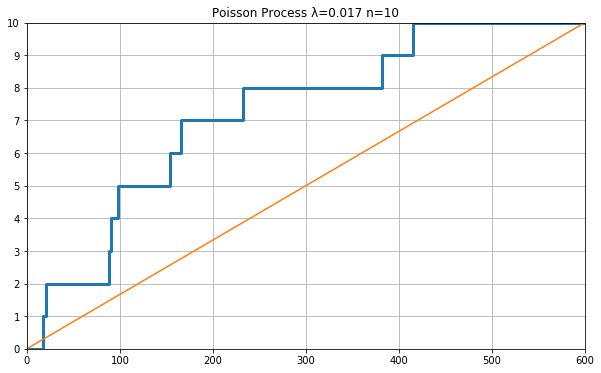

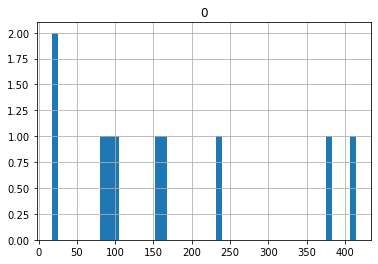

In [40]:
random.seed(41)
failure = PoissonDistribution(λ=1/60, N=10, plot=True)
failure = pd.DataFrame(failure) 
failure.mean()
failure.hist(bins=50)

####Passengers in peak hours using Poisson-Distribution(Optimal)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CFEBB2B808>]],
      dtype=object)

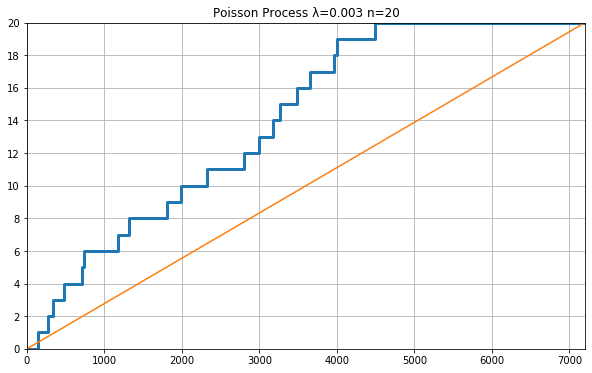

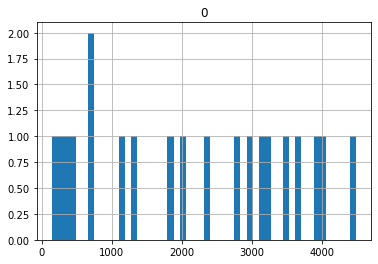

In [41]:
cus = PoissonDistribution(λ=10/3600, N=20, plot=True)
cus = pd.DataFrame(cus) 
cus.mean()
cus.hist(bins=50)

### 11. Conclusion
In this project, successful simulation of the trains is created between London and Birmingham station taking care of all the assumptions. Trains schedule were created using simulation. Signalling block between London Old Oak station and Birmingham Interchange is used to build the simulation.
As per our assumptions, by running multipule simulation by considering trains, signalling block and wait time it is observed that a train is taking 44-50 minutes to complete the journey from London to Birmingham.

### 12 References


*  [Math](https://docs.python.org/3/library/math.html,https://docs.python.org/3/library/math.html)
*  [Pandas](https://pandas.pydata.org/pandas-docs/stable/,https://docs.scipy.org/doc/scipy/reference/stats.html)
*  [Python](https://pythonhosted.org/SimPy/Manuals/Manual.html,%20)
*  [Simpy](https://pythonhosted.org/SimPy/Manuals/Manual.html)



